# **Etude du Papier de Recherche: *A Unified Framework for U-Net Design and Analysis***

Ce notebook s’inscrit dans le cadre du projet de la matière Generative models & Simulation du master MS2A de Sorbonne Université et a pour objectif d’analyser de manière rigoureuse l’article de recherche **“A Unified Framework for U-Net Design and Analysis”**, qui propose un cadre mathématique unifié pour la conception, l’interprétation et l’analyse des architectures de type U-Net.

L’objectif principal de ce travail est double :

- **Comprendre et formaliser** les principes théoriques sous-jacents aux architectures U-Net, en les replaçant dans un cadre abstrait fondé sur des opérateurs d’encodage, de décodage et de projections multi-échelles.
- **Adopter une approche algorithmique**, en traduisant ce cadre unifié en une implémentation concrète, simplifiée mais fidèle à l’esprit de l’article, afin d’en illustrer les apports sur des données synthétiques contrôlées.

Dans cette optique, le notebook est structuré de manière progressive. Il débute par une présentation détaillée du problème étudié et des limites des approches classiques. Il introduit ensuite la définition formelle du U-Net telle que proposée par les auteurs, avant d’en extraire les idées clés et les intuitions théoriques essentielles. Enfin, une implémentation algorithmique est proposée et analysée expérimentalement, permettant d’évaluer l’influence des choix architecturaux et des hyperparamètres.

**Auteurs:** Pierre Fontbonne & Erwan Ouabdesselam

## **1. Contexte et problématique de l’article**

### **1.1. Pourquoi s’intéresser aux architectures U-Net ?**

L’article prend pour objet d’étude les architectures de type U-Net, devenues centrales dans de nombreuses applications du deep learning où l’entrée et la sortie partagent une structure spatiale comparable. Leur usage dépasse aujourd’hui largement le cadre initial de la segmentation d’images et concerne également des tâches de reconstruction, de débruitage ou certains modèles génératifs.

Le point clé mis en avant par les auteurs est le rôle fondamental joué par la structure multi-échelles des U-Nets. La combinaison d'une phase de réduction de résolution et d'une phase de reconstruction permet de capturer à la fois des informations globales et locales. Les skip connections entre niveaux de résolution comparables assurent la transmission d’informations fines, souvent cruciales pour la qualité de la sortie.

Cependant, cette compréhension reste en grande partie qualitative. L’article s’inscrit dans le constat que, malgré leur efficacité empirique, les U-Nets sont rarement analysés comme des objets mathématiques à part entière, ce qui limite la compréhension de leurs mécanismes essentiels.


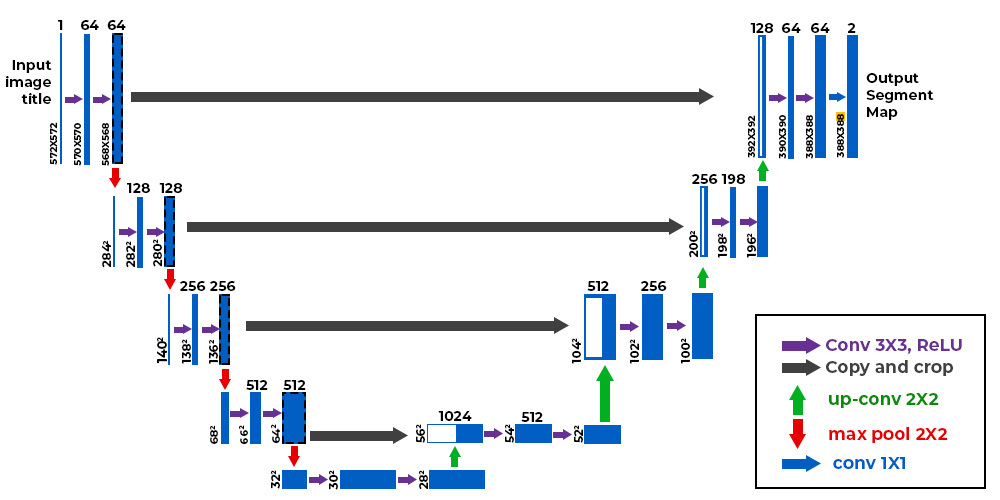



### **1.2. Problème étudié dans l’article**

Le problème central abordé par les auteurs peut être formulé comme suit : comment définir et analyser rigoureusement les architectures de type U-Net, indépendamment des choix d’implémentation spécifiques, afin d’en dégager des propriétés structurelles fondamentales ?

Plus précisément, l’article cherche à construire un cadre mathématique permettant :
- de donner une définition abstraite des U-Nets,
- de comparer différentes variantes sur une base commune,
- et d’analyser leur comportement lorsque la résolution augmente ou que la structure multi-échelles se raffine.

Cette démarche vise à dépasser une description purement architecturale pour accéder à une compréhension plus théorique de ces modèles.



### **1.3. Types de données et cadres applicatifs**

Le cadre proposé dans l’article est formulé de manière suffisamment générale pour s’appliquer à des situations où les données peuvent être vues comme des fonctions ou des champs définis sur un domaine $X$. Cette abstraction permet d’englober aussi bien des données discrétisées sur des grilles régulières (images, volumes) que des domaines plus généraux.

Les tâches considérées incluent notamment :
- la segmentation et la reconstruction,
- le débruitage,
- l’apprentissage d’opérateurs entre espaces fonctionnels, comme dans certains problèmes de modélisation de PDE,
- ainsi que des applications aux modèles génératifs, en particulier les modèles de diffusion.

Ce choix de généralité est central dans la démarche des auteurs, car il permet de dissocier la structure du U-Net du cadre discret dans lequel il est souvent implémenté.

### **1.4. Limites des approches existantes**

Avant ce travail, l’analyse des architectures U-Net souffre principalement de l’absence d’un formalisme commun. Les comparaisons entre variantes reposent le plus souvent sur des critères d’implémentation, sans permettre d’identifier clairement les mécanismes mathématiques responsables de leurs performances.

De plus, les résultats théoriques existants sont souvent fragmentaires et spécifiques à certains cas particuliers. Il manque un langage unifié permettant de relier la structure multi-échelles des U-Nets à des propriétés telles que la stabilité, l’auto-similarité ou le comportement asymptotique en haute résolution.

Enfin, les formulations classiques supposent fréquemment des domaines standards, ce qui limite l’intégration explicite de contraintes géométriques ou physiques pourtant centrales dans de nombreuses applications scientifiques.



### **1.5. Contributions principales de l’article**

L’article apporte plusieurs contributions majeures qui structurent la suite de ce notebook.

Premièrement, les auteurs proposent une définition mathématique rigoureuse des architectures de type U-Net, permettant de mettre en évidence leur structure d’auto-similarité et d’étudier leur comportement en régime de haute résolution. Ce cadre permet également d’établir un lien formel avec les ResNets.

Deuxièmement, l’article introduit la classe des **Multi-ResNets**, construites sur des hiérarchies de sous-espaces d’ondelettes orthogonales. Dans ces architectures, l’encodeur est fixé par le choix de la base fonctionnelle, ce qui permet d’injecter explicitement des informations géométriques ou physiques dans le modèle.

Enfin, les auteurs analysent les modèles de diffusion dans une base de Haar et montrent que les composantes de haute fréquence sont dominées par le bruit plus rapidement que les basses fréquences. Cette analyse fournit une justification théorique de l’usage d’opérations de type average pooling dans les U-Nets employés pour les modèles de diffusion.

## **2. Cadre méthodologique proposé**

Nous commençons par rappeler la définition formelle d’un U-Net telle qu’elle est formulée dans l’article.

### **Définition de l'architecture U-Net** 

Soient $V$ et $W$ des espaces mesurables.  
Un **U-Net** $\mathcal{U} = (\mathcal{V}, \mathcal{W}, \mathcal{E}, \mathcal{D}, \mathcal{P}, U_0)$ est défini par les six composantes suivantes :

1. **Sous-espaces d’encodage**  
   $\mathcal{V} = (V_i)_{i=0}^{\infty}$ est une suite croissante de sous-ensembles de $V$ telle que
   $$
   \lim_{i \to \infty} V_i = V.
   $$

2. **Sous-espaces de décodage**  
   $\mathcal{W} = (W_i)_{i=0}^{\infty}$ est une suite croissante de sous-ensembles de $W$ telle que
   $$
   \lim_{i \to \infty} W_i = W.
   $$

3. **Opérateurs d’encodage**  
   $\mathcal{E} = (E_i)_{i=0}^{\infty}$, où
   $$
   E_i : V_i \to V_i,
   $$
   et l’on note
   $$
   E_i(v_i) = \tilde{v}_i.
   $$

4. **Opérateurs de décodage**  
   $\mathcal{D} = (D_i)_{i=1}^{\infty}$, où
   $$
   D_i : W_{i-1} \times V_i \to W_i,
   $$
   et l’on note
   $$
   D_i(w_{i-1} \mid v_i).
   $$
   La composante $v_i$ est appelée la **connexion de saut** (*skip connection*).

5. **Opérateurs de projection**  
   $\mathcal{P} = (P_i)_{i=0}^{\infty}$, où
   $$
   P_i : V \to V_i,
   $$
   tels que
   $$
   P_i(v_i) = v_i \quad \text{pour tout } v_i \in V_i.
   $$

6. **Goulot d’étranglement (bottleneck)**  
   $U_0$ est l’application
   $$
   U_0 : V_0 \to W_0,
   $$
   qui permet une représentation compressée de l’entrée.

Le U-Net à la résolution $i$ est l’application
$$
U_i : V_i \to W_i
$$
définie récursivement par
$$
U_i(v_i) = D_i\bigl(U_{i-1}(P_{i-1}(\tilde{v}_i)) \mid \tilde{v}_i\bigr),
\qquad i = 1, 2, \ldots
$$

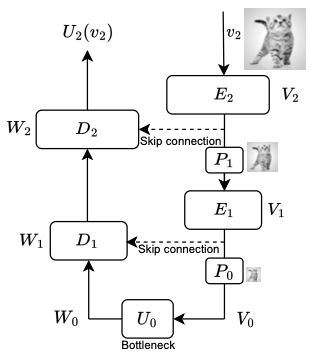

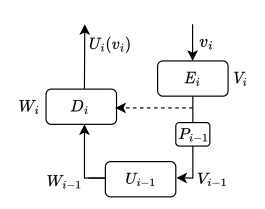

**Lecture et interprétation de la définition.**  
La Définition 1 proposée dans l’article fournit une description abstraite des architectures de type U-Net, indépendante des choix d’implémentation concrets. Elle permet en particulier de raisonner sur les U-Nets comme des opérateurs agissant entre des espaces structurés par niveaux de résolution, plutôt que comme de simples assemblages de blocs convolutifs.

Un point central de cette définition est l’introduction explicite de suites d’espaces $(V_i)$ et $(W_i)$, qui matérialisent la notion de résolution finie. Dans l’interprétation proposée par les auteurs, un U-Net ne travaille jamais directement sur les espaces continus $V$ et $W$, mais sur des approximations successives de ces espaces. Cette formulation rend explicite le caractère multi-échelles de l’architecture et permet d’envisager les U-Nets comme des approximations d’opérateurs définis sur des espaces fonctionnels.

La définition clarifie également le rôle distinct des différents opérateurs. Les opérateurs d’encodage et de projection organisent le passage entre résolutions, tandis que les opérateurs de décodage apprennent la reconstruction progressive de la sortie, en s’appuyant sur les informations transmises par les skip connections. Cette dissociation permet de dépasser la vision symétrique encodeur-décodeur souvent utilisée dans les descriptions classiques.

Enfin, la relation récursive définissant les opérateurs $U_i$ met en évidence une structure auto-similaire : chaque niveau du U-Net s’appuie sur le précédent pour affiner l’approximation à une résolution plus fine. Cette organisation, interprétée dans l’article comme une forme de préconditionnement par sous-espaces, joue un rôle clé dans l’analyse théorique proposée et prépare les liens établis ultérieurement avec d’autres architectures, notamment les ResNets.

(Est ce qu'on parle de la partie high resolution scaling ???)

### **Lien entre U-Nets et architectures résiduelles**
Un autre apport conceptuel important du cadre proposé est la mise en évidence d’un lien formel entre les architectures de type U-Net et les réseaux résiduels (ResNets). Les auteurs montrent qu’à chaque niveau de résolution, un U-Net peut être interprété comme un réseau résiduel, dont l’approximation est construite relativement au U-Net de résolution inférieure.

Dans cette lecture, le modèle apprend principalement une correction résiduelle associée au passage à une résolution plus fine, tandis que l’approximation grossière fournie par le niveau inférieur joue le rôle de référence. Cette interprétation fournit une justification théorique à l’usage fréquent de blocs résiduels dans les encodeurs et décodeurs des U-Nets modernes.

Ce point de vue met en évidence que les U-Nets ne se réduisent pas à une simple structure encodeur–décodeur, mais peuvent être compris comme des architectures hiérarchiques, dans lesquelles l’apprentissage s’organise comme une succession de corrections multi-échelles.

### Choix des sous-espaces d’encodage comme a priori de modélisation

L’article met en évidence un point qui n’apparaît pas dans les descriptions architecturales classiques : le choix des sous-espaces d’encodage $\mathcal V$ constitue en lui-même un a priori de modélisation. Ce choix fixe une représentation multi-échelles initiale sur laquelle le U-Net opère, indépendamment de tout apprentissage.

Dans cette perspective, l’encodeur n’est pas chargé de construire la décomposition multi-échelles, mais d’en corriger les défauts lorsque celle-ci n’est pas parfaitement adaptée au problème considéré. Cela explique pourquoi les encodeurs sont naturellement modélisés comme des opérateurs résiduels, et pourquoi, dans le cas limite des Multi-ResNets, l’encodeur peut être réduit à l’identité, toute la structure multi-échelles étant imposée par le choix de $\mathcal V$.





Importance des skip connections 

Importance du precoditionning

Importance du choix de la base 

# Expériences sur données synthétiques 1D  
## Validation contrôlée de mécanismes architecturaux (cadre U-Net)

Avant d’aborder des applications sur données réelles, cette section propose une étude sur signaux synthétiques 1D afin d’analyser, dans un cadre contrôlé, l’impact de certains choix architecturaux mis en avant dans l'article.

L’objectif n’est pas d’optimiser les performances sur une tâche réaliste, mais d’isoler et de comparer des mécanismes précis dans un contexte simple et interprétable.

### Objectifs des expériences

Les expériences menées visent à évaluer empiriquement :

1. **L’effet des connexions résiduelles**, interprétées comme l’apprentissage d’une correction par rapport à une approximation initiale.

2. **Le rôle du préconditionnement**, introduit pour améliorer le conditionnement du problème inverse et faciliter l’optimisation.

3. **Une comparaison quantitative cohérente**, en évaluant l’ensemble des modèles sur un même jeu de test synthétique, strictement identique.

Cette analyse se place dans une logique de validation de principes architecturaux, en lien direct avec les hypothèses du papier, plutôt que dans une démarche de comparaison de performances absolues.

Chaque paire de données est générée selon le modèle de bruit additif suivant :

$$[
Y = X + \varepsilon, 
\qquad \varepsilon \sim \mathcal{N}(0, \sigma_{\text{noise}}^2 I)
]$$

où $( X \in \mathbb{R}^L )$ est le signal propre et $Y$ son observation bruitée.

La tâche d’apprentissage correspond à un **problème de débruitage**, formulé comme une régression visant à reconstruire $X$ à partir de $Y$.

### Structure des signaux propres

Les signaux propres sont construits comme une superposition de composantes élémentaires, activables indépendamment :

- **composantes globales lisses** : somme de sinusoïdes (basses fréquences),
- **discontinuités intermédiaires** (*steps*, optionnelles),
- **événements localisés** (*spikes*, optionnels).

Cette construction permet de générer des signaux contenant simultanément des structures globales et locales, ce qui constitue un cadre adapté à l’étude d’architectures multi-échelle de type U-Net.


La classe `Signal1DConfig` permet de contrôler explicitement la difficulté et la structure du problème inverse.

Les paramètres principaux sont :
- `L` : longueur du signal,
- `sigma_noise` : niveau de bruit additif,
- `use_steps` : activation des discontinuités,
- `use_spikes` : activation des événements localisés,
- `do_standardize` : standardisation du signal propre.

Cette paramétrisation modulaire permet de générer des jeux de données adaptés aux mécanismes étudiés, tout en garantissant des comparaisons équitables entre architectures.


## Modèles entraînés

### 1) Backbone commun : une fonction $f_\theta$
Les trois variantes partagent exactement le même réseau $f_\theta$, implémenté par `MLPResNet` (un MLP à blocs résiduels) :

- entrée : $Y \in \mathbb{R}^L$ (signal bruité),
- sortie : un vecteur dans $\mathbb{R}^L$,
- rôle : produire une **correction** ou un **résidu** selon le mode choisi.

L’objectif est d’isoler l’effet de l’“enveloppe” (baseline, résiduel, préconditionné) sans modifier la capacité du backbone.

### 2) Un opérateur unique capturant trois variantes
La classe `DenoiserOperator` encode trois formes d’opérateurs de reconstruction
$$
\hat X = \mathcal{T}_\theta(Y),
$$
qui ne diffèrent que par la manière dont la sortie du réseau est combinée avec l’entrée.

#### (a) Baseline : reconstruction directe
$$
\hat X = f_\theta(Y).
$$
Il s’agit de la référence la plus simple : l’ensemble du signal doit être reconstruit directement par le réseau.

#### (b) Résiduel : apprentissage d’une correction (skip identité)
$$
\hat X = Y + f_\theta(Y).
$$
Dans ce cas, le réseau apprend principalement une **correction** par rapport à l’opérateur identité.  
C’est l’analogue 1D le plus simple d’un *skip connection*, qui facilite l’optimisation en demandant au modèle d’expliquer essentiellement ce qui doit être corrigé.

#### (c) Préconditionné : reconstruction autour d’une approximation initiale
$$
\hat X = P(Y) + f_\theta(Y).
$$
Le terme $P(Y)$ joue le rôle de **préconditionneur** : il fournit une première estimation structurée du signal, tandis que le réseau apprend le complément.

Dans notre implémentation, $P$ est volontairement simple et interprétable :
- `identity` : $P(Y) = Y$ (cas résiduel),
- `ma` : $P(Y) = \mathrm{MA}(Y)$ (moyenne glissante), qui approxime une composante lisse et de basse fréquence.

### 3) Parallèle avec un U-Net (correction autour d’un niveau grossier)
Dans le papier, une interprétation centrale est qu’à chaque échelle, un U-Net peut être vu comme la somme de :
- une **approximation grossière** produite à plus basse résolution (préconditionneur),
- une **correction** apprise à cette échelle (résidu).

Le mode *preconditioned* reproduit exactement cette logique en version 1D :
- $P(Y)$ joue le rôle de la composante **grossière**,
- $f_\theta(Y)$ apprend la composante **fine** ou **résiduelle**.

Même si $P$ est ici une moyenne glissante (et non un encodeur multi-échelle complet), l’expérience permet de tester explicitement le mécanisme clé :
**apprendre une correction autour d’un opérateur initial raisonnable**, plutôt que de reconstruire le signal entièrement à partir de zéro.

## Analyse des résultats

On compare trois opérateurs de débruitage entraînés sur le même générateur de signaux :

- **baseline** : $\hat X = f_\theta(Y)$  
- **residual** : $\hat X = Y + f_\theta(Y)$  
- **preconditioned** : $\hat X = P(Y) + f_\theta(Y)$ (ex : MA ou Haar)

L’objectif est de quantifier :
1. la **qualité finale** (erreur de reconstruction sur un jeu de test commun),
2. la **vitesse de convergence** (loss vs steps),
3. le **comportement qualitatif** sur différentes structures (lisse, steps, spikes).

### 1) Convergence : train/val loss vs steps

On superpose les courbes de loss pour comparer la **vitesse de convergence** et la **stabilité**.
C’est un point clé : les formulations résiduelle et préconditionnée sont censées rendre l’optimisation plus favorable.

### 2) Comparaison qualitative sur un même signal

On fixe un même couple $(X, Y)$ et on trace :
- le signal propre $X$,
- l’observation bruitée $Y$,
- les reconstructions $\hat X$ des trois modèles.

Cela permet de voir *où* chaque formulation aide :
- reconstruction globale,
- restauration des discontinuités (steps),
- restauration des détails localisés (spikes).

### 3) Comparaison quantitative sur un jeu de test commun

Pour éviter de tirer des conclusions sur un seul exemple, on évalue chaque modèle sur un ensemble de $N$ signaux test,
générés avec les mêmes paramètres et des seeds fixés.

On reporte :
- la moyenne de la MSE,
- l'écart-type (dispersion),
- éventuellement quelques percentiles (robustesse).

Questions à se poser :
- Pourquoi c'est un choix judicieux les ondelettes de Haar? 


Points à retenir du papier :
- Le U-Net peut être vu comme une forme réorganisée d’un ResNet. Autrement dit, le U-Net utilise une structure similaire au ResNet, mais adaptée pour la segmentation d’images en organisant les niveaux de résolution de manière plus structurée.

- Multi resnet


- Pour des images un bon choix de bases est les bases de Haar


- Pas capter la partie sur les PDE


Limites / ouvertures :
- Future work should hence investigate how to optimally choose V for a problem at hand

Sources :
- Image du unet :  https://datasciencetoday.net/index.php/fr/deep-learning/228-unet 

In [ ]:
Nouvelle version plus propre

## Expériences sur données synthétiques 1D
### Validation contrôlée de mécanismes architecturaux (cadre unifié des U-Nets)

Avant d’aborder des applications sur des données réelles, cette section propose une étude sur signaux synthétiques 1D afin d’analyser, dans un cadre contrôlé, l’impact de plusieurs choix architecturaux mis en avant dans l’article *A Unified Framework for U-Net Design and Analysis*.  

L’objectif n’est pas d’optimiser des performances absolues sur une tâche réaliste, mais d’isoler et de comparer des mécanismes précis dans un contexte simple, interprétable, et reproductible.

---

## Objectifs des expériences

Les expériences menées visent à évaluer empiriquement les points suivants, directement liés aux contributions du papier :

1. **Importance des skip connections**  
   Tester l’hypothèse que les connexions de saut sont essentielles pour reconstruire les composantes fines (hautes fréquences) et préserver l’information locale, en particulier lorsque l’encodeur est peu ou pas appris.  
   Une ablation sera réalisée en remplaçant les tenseurs de skip connections par des zéros, sans changer le reste de l’architecture, afin d’obtenir une comparaison équitable.

2. **Importance du préconditionnement (self-similarity / apprentissage par corrections)**  
   Étudier des opérateurs de reconstruction sous forme résiduelle ou préconditionnée, typiquement :
   \[
   \widehat{x} \;=\; p(y) \;+\; f_\theta\!\big(y - p(y)\big),
   \]
   où \(p(y)\) est une approximation initiale (préconditionneur) et \(f_\theta\) apprend une correction.  
   L’objectif est de montrer que le préconditionnement améliore le conditionnement du problème inverse et facilite l’optimisation, conformément à l’interprétation du U-Net comme un mécanisme de préconditionnement entre résolutions.

3. **Rôle des opérateurs d’encodage, de décodage et de projection**  
   Mettre en évidence que l’encodeur et le décodeur ont des rôles fondamentalement différents :  
   l’encodeur compresse ou change de représentation l’entrée, tandis que le décodeur apprend la transition vers une reconstruction plus fine, en s’appuyant sur les informations transmises par les skip connections.  
   On compare :
   - un **U-Net 1D standard** (encodeur/décodeur appris),
   - un **Multi-ResNet 1D** où l’encodeur repose sur une **décomposition multirésolution fixe** (type ondelettes / projections) et où l’apprentissage est majoritairement porté par le décodeur.

4. **Analyse fréquentielle et lien avec les arguments multirésolution (LF vs HF)**  
   Afin de relier les résultats aux intuitions théoriques du papier, l’évaluation ne se limite pas à une MSE globale.  
   On analyse également séparément l’erreur sur :
   - les **basses fréquences (LF)**, liées à la structure globale,
   - les **hautes fréquences (HF)**, liées aux détails, discontinuités et événements localisés.  
   Ceci permet notamment d’illustrer le mécanisme discuté dans le papier : l’information HF peut être dominée par le bruit plus rapidement que l’information LF, ce qui justifie l’usage fréquent d’opérateurs de pooling et de multirésolution.

5. **Expérience synthétique dédiée au préconditionnement (type Fig. 20 du papier)**  
   En complément du débruitage, une expérience synthétique simple (apprentissage de fonctions 1D) sera reproduite pour illustrer que l’efficacité d’un préconditionneur dépend du problème : un préconditionneur proche de la solution agit comme une excellente initialisation et accélère fortement l’apprentissage, tandis qu’un préconditionneur inadapté peut dégrader la convergence.

---

## Cadre de données : débruitage 1D contrôlé

Chaque paire \((X,Y)\) est générée selon un modèle de bruit additif :
\[
Y = X + \varepsilon,\qquad \varepsilon \sim \mathcal{N}(0,\sigma^2 I).
\]
La tâche correspond à un problème de débruitage formulé comme une régression visant à reconstruire \(X\) à partir de \(Y\).

---

## Structure des signaux propres

Les signaux propres sont construits comme une superposition de composantes élémentaires, activables indépendamment :

- **composantes globales lisses** : somme de sinusoïdes (basses à moyennes fréquences),
- **discontinuités** : signaux par morceaux via des *steps*,
- **événements localisés** : *spikes* gaussiens (structures fines et localisées).

Cette construction permet de générer des signaux combinant simultanément des structures globales et locales, ce qui est adapté à l’étude d’architectures multirésolution de type U-Net.

---

## Métriques et protocole de comparaison

Pour garantir une comparaison équitable, tous les modèles sont évalués sur un même jeu de test synthétique strictement identique.

Les métriques reportées incluront :
- **MSE globale** sur le signal reconstruit,
- **MSE basse fréquence (LF)** et **MSE haute fréquence (HF)** via une décomposition fréquentielle (filtrage ou base multirésolution),
- **courbes d’apprentissage** (train/val) afin d’analyser stabilité et vitesse de convergence,
- optionnellement, une analyse de robustesse en fonction du niveau de bruit.

---

## Remarque importante sur la décomposition multirésolution

Dans les expériences 1D, plusieurs opérateurs multirésolution seront considérés.  
Lorsque l’on utilise une approximation multirésolution obtenue par average pooling multi-niveaux (low-pass), elle doit être interprétée comme un opérateur **Haar-like** au sens d’une approximation multi-échelle (passe-bas), mais pas nécessairement comme une transformée orthogonale complète (DWT) si les coefficients de détails ne sont pas explicitement construits.

Une version avec une vraie décomposition en sous-bandes (approximation + détails), plus proche d’une DWT, sera introduite pour étudier plus finement l’impact de la représentation multirésolution et relier directement l’analyse LF/HF aux arguments du papier.

## Analyse expérimentale : impact du préconditionnement sur le débruitage 1D
### Objectif de l’expérience

Cette expérimentation vise à comparer plusieurs formulations d’un même modèle de débruitage 1D, toutes basées sur un **MLP strictement identique**, afin d’isoler l’impact de la *formulation du problème* plutôt que celui de la capacité du réseau.

Plus précisément, on compare :
- une approche **directe** (baseline),
- une approche **résiduelle**,
- plusieurs variantes **préconditionnées**, où le réseau apprend uniquement une correction autour d’une approximation grossière du signal propre.

L’hypothèse centrale est que **fournir une bonne approximation initiale du signal propre** facilite l’apprentissage et améliore la reconstruction finale, en particulier sur les hautes fréquences.

## Expérience A – Intérêt du préconditionnement pour le débruitage de signaux 1D

L’objectif de cette première expérience est d’étudier l’impact du **préconditionnement** sur l’apprentissage d’un modèle de débruitage de signaux 1D.  
On cherche à déterminer si le fait de transformer l’entrée du réseau à l’aide d’un opérateur simple et non appris (filtrage moyenne mobile, ondelettes de Haar) permet :

- d’améliorer la convergence,
- de faciliter l’apprentissage des composantes pertinentes du signal,
- et in fine d’obtenir de meilleures performances que le modèle de référence.

Cette étude s’inscrit directement dans l’esprit du papier de recherche, où le préconditionnement est interprété comme un moyen de **simplifier le problème appris par le réseau**.

Device: mps


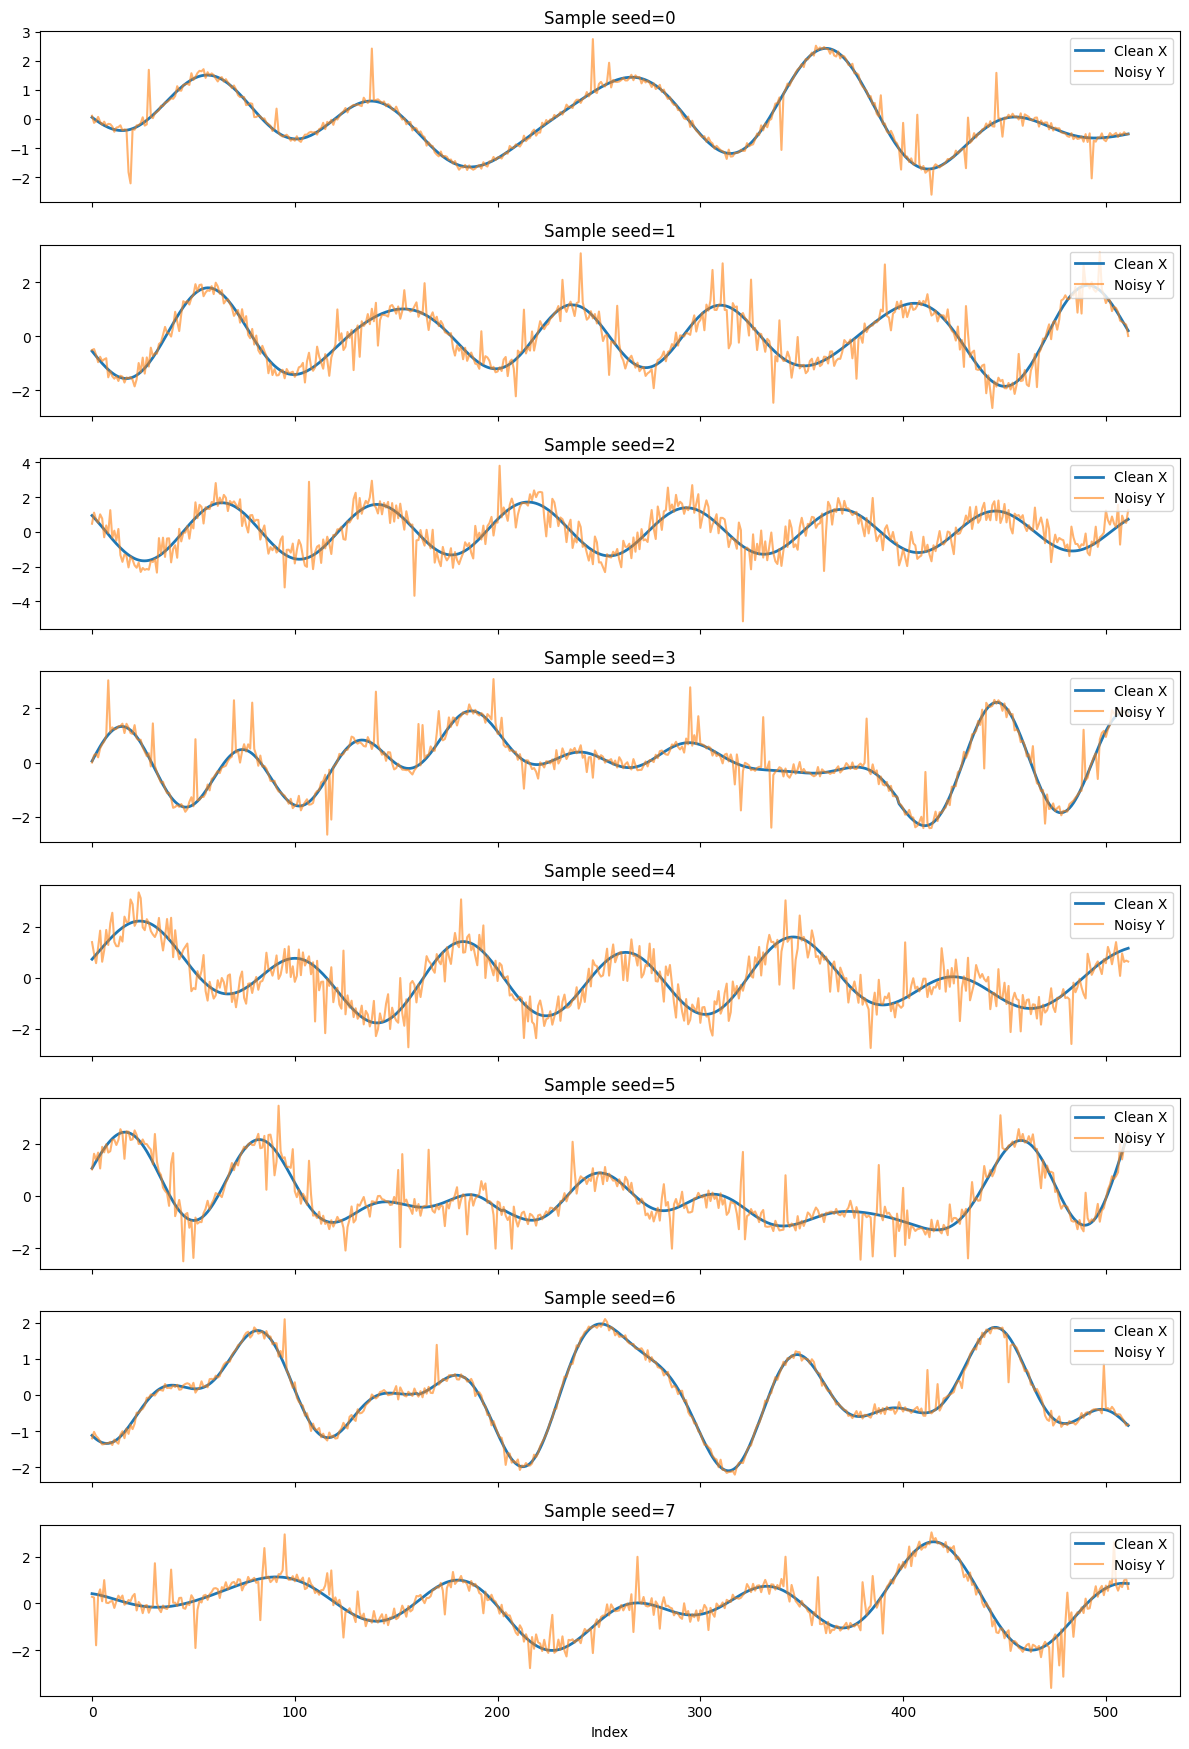

In [59]:
# Imports
import torch
import matplotlib.pyplot as plt

from src.data.signal_1d import Signal1DConfig, generate_pair, Signal1DDataModule

# (Optionnel) device pour les modèles, pas nécessaire pour generate_pair
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device:", device)

# Config simple pour visualisation (la config d'entraînement viendra de Hydra/YAML)
cfg_viz = Signal1DConfig(
    L=512,
    use_steps=True,
    use_spikes=True,
    do_standardize=True,
)

# Visualisation de quelques paires (qualitatif uniquement)
n_samples = 8
fig, axes = plt.subplots(n_samples, 1, figsize=(12, 2.2 * n_samples), sharex=True)

for i in range(n_samples):
    x_clean, y_noisy = generate_pair(cfg_viz, seed=i)

    ax = axes[i]
    ax.plot(x_clean.cpu().numpy(), label="Clean X", linewidth=2)
    ax.plot(y_noisy.cpu().numpy(), label="Noisy Y", alpha=0.6)
    ax.set_title(f"Sample seed={i}")
    ax.legend(loc="upper right")

plt.xlabel("Index")
plt.tight_layout()
plt.show()

In [60]:
# Test set reproductible via le DataModule (recommandé)
dm = Signal1DDataModule(
    batch_size=256,
    n_train=20000,
    n_val=5000,
    n_test=5000,
    L=512,
    use_steps=True,
    use_spikes=True,
    do_standardize=True,
    seed=0,
    num_workers=0,   # pour être ultra déterministe au début
    pin_memory=False,
    persistent_workers=False,
)

dm.setup("test")
test_loader = dm.test_dataloader()

# Exemple: récupérer un batch fixe pour des comparaisons qualitatives
y_batch, x_batch = next(iter(test_loader))
print(y_batch.shape, x_batch.shape)

torch.Size([256, 512]) torch.Size([256, 512])


In [61]:
import torch

from src.models.wavelet_1d import haar_dwt_1d, haar_lowpass_reconstruct
from src.models.regressors import moving_average_1d  # si tu veux comparer MA

In [62]:
from src.models.wavelet_1d import haar_lowpass_reconstruct

def mse(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    return torch.mean((a - b) ** 2)

@torch.no_grad()
def metrics_haar_signal(x_hat: torch.Tensor, x_true: torch.Tensor, levels: int = 3) -> dict:
    """
    LF/HF computed in signal space:
      LF = Haar low-pass reconstruction
      HF = residual (x - LF)
    """
    if x_hat.dim() == 1:
        x_hat = x_hat[None, :]
        x_true = x_true[None, :]

    # Global MSE
    mse_all = mse(x_hat, x_true)

    # LF components (signals)
    lf_hat = haar_lowpass_reconstruct(x_hat, levels=levels)
    lf_true = haar_lowpass_reconstruct(x_true, levels=levels)

    # HF components (signals)
    hf_hat = x_hat - lf_hat
    hf_true = x_true - lf_true

    mse_lf = mse(lf_hat, lf_true)
    mse_hf = mse(hf_hat, hf_true)

    return {
        "mse": mse_all.item(),
        "mse_lf_signal": mse_lf.item(),
        "mse_hf_signal": mse_hf.item(),
    }

In [63]:
y_batch, x_batch = next(iter(test_loader))

x_id = y_batch
x_haar_lp = haar_lowpass_reconstruct(y_batch, levels=3)
x_ma = moving_average_1d(y_batch, kernel_size=9)

print("Identity:", metrics_haar_signal(x_id, x_batch, levels=3))
print("Haar LP :", metrics_haar_signal(x_haar_lp, x_batch, levels=3))
print("MA      :", metrics_haar_signal(x_ma, x_batch, levels=3))

Identity: {'mse': 0.1725393384695053, 'mse_lf_signal': 0.021135961636900902, 'mse_hf_signal': 0.15140336751937866}
Haar LP : {'mse': 0.049337439239025116, 'mse_lf_signal': 0.021135961636900902, 'mse_hf_signal': 0.028201477602124214}
MA      : {'mse': 0.019589822739362717, 'mse_lf_signal': 0.013929142616689205, 'mse_hf_signal': 0.005660679191350937}


In [64]:
cfg_skips = Signal1DConfig(
    L=512,
    use_steps=True,
    use_spikes=True,
    do_standardize=True,

    spikes_n_min=3,
    spikes_n_max=10,
    spikes_width_min=0.002,
    spikes_width_max=0.02,

    impulsive_prob_min=0.0,
    impulsive_prob_max=0.02,
    impulsive_amp_min=0.8,
    impulsive_amp_max=1.5,

    sigma_noise_min=0.05,
    sigma_noise_max=0.60,
)

# quick batch
x, y = generate_pair(cfg_skips, seed=0)
print("One sample ok:", x.shape, y.shape)

# test on a small set of seeds
seeds = list(range(64))
ms = {"id": [], "haar": [], "ma": []}

for s in seeds:
    x_true, y_noisy = generate_pair(cfg_skips, seed=s)
    x_id = y_noisy
    x_haar = haar_lowpass_reconstruct(y_noisy, levels=3)
    x_ma = moving_average_1d(y_noisy, kernel_size=9)

    ms["id"].append(metrics_haar_signal(x_id, x_true, levels=3)["mse"])
    ms["haar"].append(metrics_haar_signal(x_haar, x_true, levels=3)["mse"])
    ms["ma"].append(metrics_haar_signal(x_ma, x_true, levels=3)["mse"])

print("Mean MSE over seeds:")
print("Identity:", sum(ms["id"]) / len(ms["id"]))
print("Haar LP :", sum(ms["haar"]) / len(ms["haar"]))
print("MA      :", sum(ms["ma"]) / len(ms["ma"]))

One sample ok: torch.Size([512]) torch.Size([512])
Mean MSE over seeds:
Identity: 0.06735756959824357
Haar LP : 0.039163665496744215
MA      : 0.008456414551801572


### Modèles comparés

Tous les modèles utilisent exactement le même backbone (MLP, même profondeur, mêmes hyperparamètres).  
Seule la *formulation de l’opérateur* change.

- **Baseline (f(y))**  
  Le réseau apprend directement une approximation du signal propre à partir du signal bruité.

- **Residual (y + f(y))**  
  Le réseau apprend une correction additive par rapport au signal bruité.

- **Precond Identity**  
  Cas limite du préconditionnement où l’approximation initiale est simplement le signal bruité.  
  Ce modèle sert principalement de point de référence.

- **Precond Haar (L = 1, L = 3)**  
  Le signal est d’abord projeté sur une approximation basse fréquence via une reconstruction Haar tronquée, puis le réseau apprend à corriger les détails manquants.

- **Precond MA (k = 9)**  
  Même idée, mais l’approximation initiale est obtenue via une moyenne glissante, agissant comme un filtre passe-bas simple.

> **Remarque**  
Le modèle résiduel (y + f(y)) ne constitue pas un préconditionnement au sens du papier.  
Il modifie la *paramétrisation* du modèle, mais ne transforme pas l’espace dans lequel le problème est posé.

Le préconditionnement, tel qu’étudié ici, repose au contraire sur l’application d’un opérateur explicite, fixe et non appris, qui agit directement sur la structure fréquentielle du signal avant l’apprentissage.

In [65]:
!python main.py task@_global_=regression data=signal_1d model=denoiser_mlp \
  seed=0 trainer.deterministic=true trainer.benchmark=false \
  model.model.mode=baseline model.model.preconditioner=identity \
  output_id=signal1d_baseline

Seed set to 0
seed: 0
output_dir: .cache
output_id: signal1d_baseline
trainer:
  _target_: pytorch_lightning.Trainer
  max_epochs: 15
  accelerator: auto
  log_every_n_steps: 10
  check_val_every_n_epoch: 1
  limit_val_batches: 1.0
  deterministic: true
  benchmark: false
  enable_checkpointing: true
  enable_progress_bar: true
  callbacks:
  - _target_: pytorch_lightning.callbacks.EarlyStopping
    monitor: val_loss
    mode: min
    patience: 10
  - _target_: pytorch_lightning.callbacks.ModelCheckpoint
    monitor: val_loss
    mode: min
    save_top_k: 1
    dirpath: ./${output_dir}/checkpoints
    filename: ${now:%Y-%m-%d_%H-%M-%S}-epoch={epoch}-val_loss={val_loss:.6f}
model:
  _target_: src.models.regression_model.RegressionModel
  model:
    _target_: src.models.regressors.DenoiserOperator
    mode: baseline
    preconditioner: identity
    ma_kernel_size: 9
    haar_levels: 3
    net:
      _target_: src.models.regressors.MLPResNet
      input_dim: ${data.d}
      output_dim: ${

In [66]:
!python main.py task@_global_=regression data=signal_1d model=denoiser_mlp \
  seed=0 trainer.deterministic=true trainer.benchmark=false \
  model.model.mode=residual model.model.preconditioner=identity \
  output_id=signal1d_residual

Seed set to 0
seed: 0
output_dir: .cache
output_id: signal1d_residual
trainer:
  _target_: pytorch_lightning.Trainer
  max_epochs: 15
  accelerator: auto
  log_every_n_steps: 10
  check_val_every_n_epoch: 1
  limit_val_batches: 1.0
  deterministic: true
  benchmark: false
  enable_checkpointing: true
  enable_progress_bar: true
  callbacks:
  - _target_: pytorch_lightning.callbacks.EarlyStopping
    monitor: val_loss
    mode: min
    patience: 10
  - _target_: pytorch_lightning.callbacks.ModelCheckpoint
    monitor: val_loss
    mode: min
    save_top_k: 1
    dirpath: ./${output_dir}/checkpoints
    filename: ${now:%Y-%m-%d_%H-%M-%S}-epoch={epoch}-val_loss={val_loss:.6f}
model:
  _target_: src.models.regression_model.RegressionModel
  model:
    _target_: src.models.regressors.DenoiserOperator
    mode: residual
    preconditioner: identity
    ma_kernel_size: 9
    haar_levels: 3
    net:
      _target_: src.models.regressors.MLPResNet
      input_dim: ${data.d}
      output_dim: ${

In [67]:
!python main.py task@_global_=regression data=signal_1d model=denoiser_mlp \
  seed=0 trainer.deterministic=true trainer.benchmark=false \
  model.model.mode=preconditioned model.model.preconditioner=identity \
  output_id=signal1d_precond_identity

Seed set to 0
seed: 0
output_dir: .cache
output_id: signal1d_precond_identity
trainer:
  _target_: pytorch_lightning.Trainer
  max_epochs: 15
  accelerator: auto
  log_every_n_steps: 10
  check_val_every_n_epoch: 1
  limit_val_batches: 1.0
  deterministic: true
  benchmark: false
  enable_checkpointing: true
  enable_progress_bar: true
  callbacks:
  - _target_: pytorch_lightning.callbacks.EarlyStopping
    monitor: val_loss
    mode: min
    patience: 10
  - _target_: pytorch_lightning.callbacks.ModelCheckpoint
    monitor: val_loss
    mode: min
    save_top_k: 1
    dirpath: ./${output_dir}/checkpoints
    filename: ${now:%Y-%m-%d_%H-%M-%S}-epoch={epoch}-val_loss={val_loss:.6f}
model:
  _target_: src.models.regression_model.RegressionModel
  model:
    _target_: src.models.regressors.DenoiserOperator
    mode: preconditioned
    preconditioner: identity
    ma_kernel_size: 9
    haar_levels: 3
    net:
      _target_: src.models.regressors.MLPResNet
      input_dim: ${data.d}
      

In [68]:
!python main.py task@_global_=regression data=signal_1d model=denoiser_mlp \
  seed=0 trainer.deterministic=true trainer.benchmark=false \
  model.model.mode=preconditioned model.model.preconditioner=haar model.model.haar_levels=1 \
  output_id=signal1d_precond_haar1

!python main.py task@_global_=regression data=signal_1d model=denoiser_mlp \
  seed=0 trainer.deterministic=true trainer.benchmark=false \
  model.model.mode=preconditioned model.model.preconditioner=haar model.model.haar_levels=3 \
  output_id=signal1d_precond_haar3

Seed set to 0
seed: 0
output_dir: .cache
output_id: signal1d_precond_haar1
trainer:
  _target_: pytorch_lightning.Trainer
  max_epochs: 15
  accelerator: auto
  log_every_n_steps: 10
  check_val_every_n_epoch: 1
  limit_val_batches: 1.0
  deterministic: true
  benchmark: false
  enable_checkpointing: true
  enable_progress_bar: true
  callbacks:
  - _target_: pytorch_lightning.callbacks.EarlyStopping
    monitor: val_loss
    mode: min
    patience: 10
  - _target_: pytorch_lightning.callbacks.ModelCheckpoint
    monitor: val_loss
    mode: min
    save_top_k: 1
    dirpath: ./${output_dir}/checkpoints
    filename: ${now:%Y-%m-%d_%H-%M-%S}-epoch={epoch}-val_loss={val_loss:.6f}
model:
  _target_: src.models.regression_model.RegressionModel
  model:
    _target_: src.models.regressors.DenoiserOperator
    mode: preconditioned
    preconditioner: haar
    ma_kernel_size: 9
    haar_levels: 1
    net:
      _target_: src.models.regressors.MLPResNet
      input_dim: ${data.d}
      output_

In [69]:
!python main.py task@_global_=regression data=signal_1d model=denoiser_mlp \
  seed=0 trainer.deterministic=true trainer.benchmark=false \
  model.model.mode=preconditioned model.model.preconditioner=ma model.model.ma_kernel_size=9 \
  output_id=signal1d_precond_ma9

Seed set to 0
seed: 0
output_dir: .cache
output_id: signal1d_precond_ma9
trainer:
  _target_: pytorch_lightning.Trainer
  max_epochs: 15
  accelerator: auto
  log_every_n_steps: 10
  check_val_every_n_epoch: 1
  limit_val_batches: 1.0
  deterministic: true
  benchmark: false
  enable_checkpointing: true
  enable_progress_bar: true
  callbacks:
  - _target_: pytorch_lightning.callbacks.EarlyStopping
    monitor: val_loss
    mode: min
    patience: 10
  - _target_: pytorch_lightning.callbacks.ModelCheckpoint
    monitor: val_loss
    mode: min
    save_top_k: 1
    dirpath: ./${output_dir}/checkpoints
    filename: ${now:%Y-%m-%d_%H-%M-%S}-epoch={epoch}-val_loss={val_loss:.6f}
model:
  _target_: src.models.regression_model.RegressionModel
  model:
    _target_: src.models.regressors.DenoiserOperator
    mode: preconditioned
    preconditioner: ma
    ma_kernel_size: 9
    haar_levels: 3
    net:
      _target_: src.models.regressors.MLPResNet
      input_dim: ${data.d}
      output_dim:

### Dynamique d’apprentissage (train / validation)

Les courbes de loss d’entraînement et de validation montrent des comportements très différents selon la formulation du modèle.


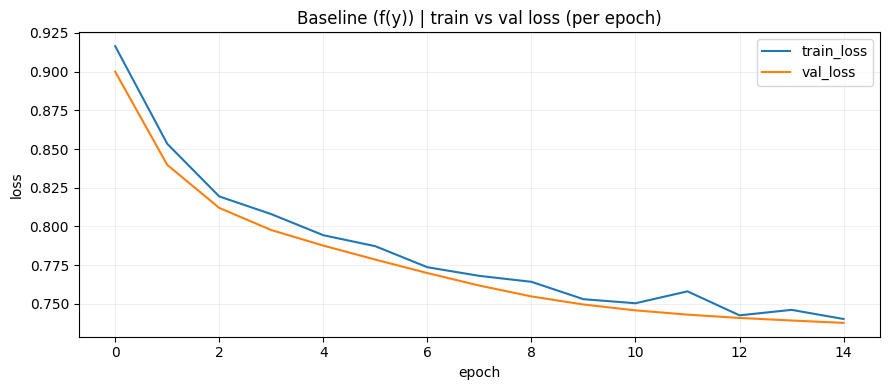

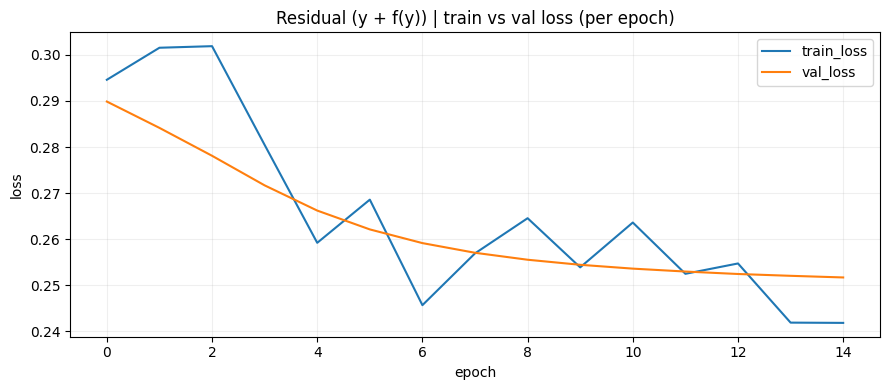

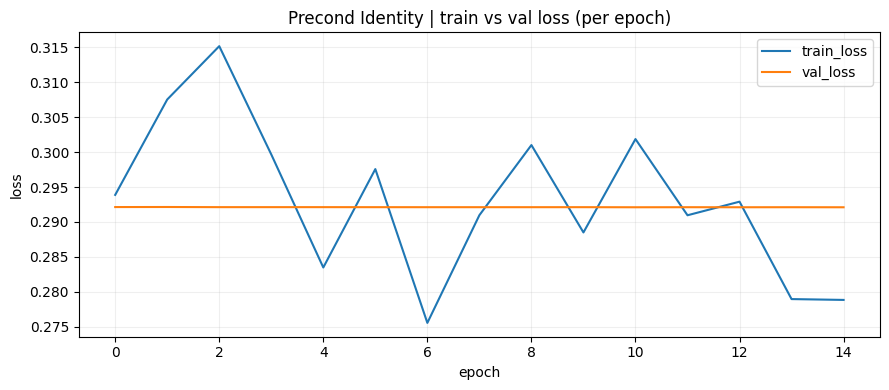

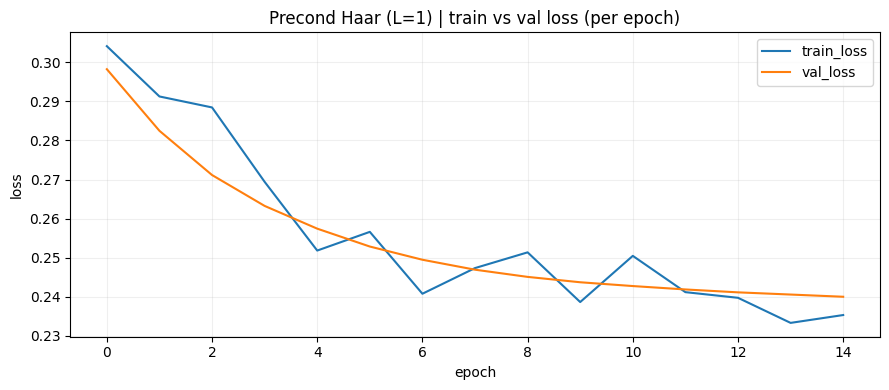

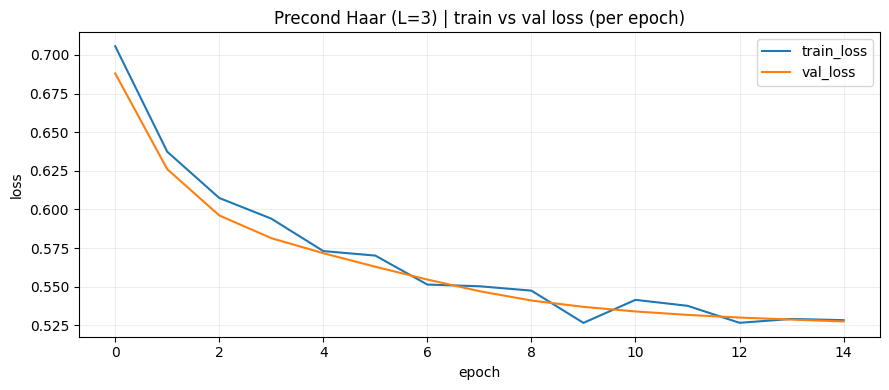

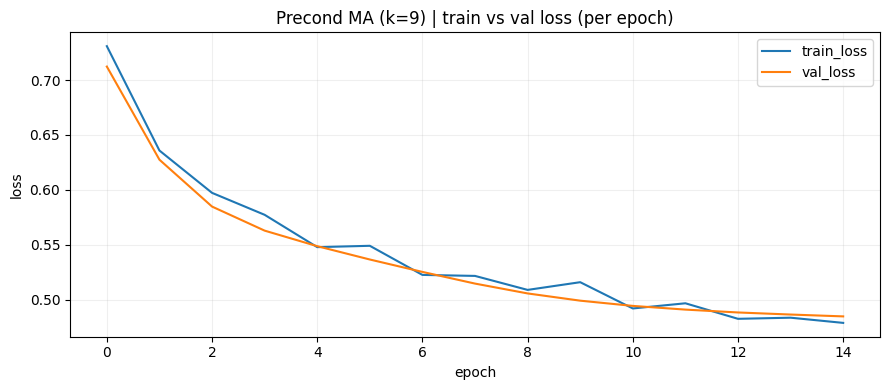

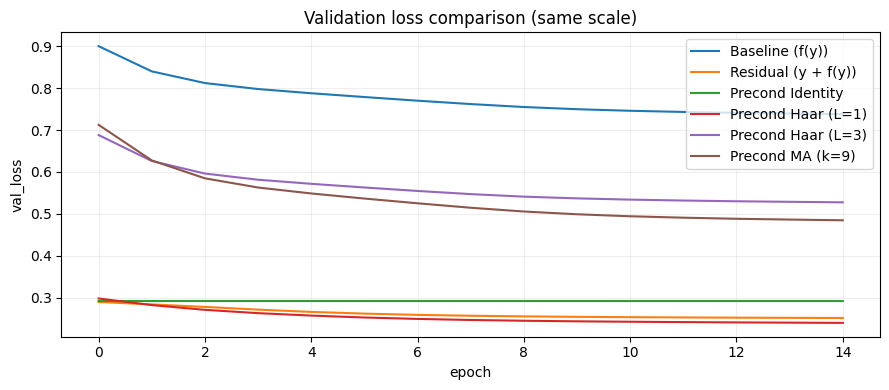

In [95]:
# ====== Imports ======
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ====== Paths (adapt if needed) ======
CACHE_DIR = "./.cache"
LOG_DIR = os.path.join(CACHE_DIR, "lightning_logs")

# ====== Your runs ======
RUN_VERSION = {
    "Baseline (f(y))": "version_6",
    "Residual (y + f(y))": "version_7",
    "Precond Identity": "version_8",
    "Precond Haar (L=1)": "version_9",
    "Precond Haar (L=3)": "version_10",
    "Precond MA (k=9)": "version_11",
}

# ====== Helpers ======
def _read_metrics(version: str, log_dir: str = LOG_DIR) -> pd.DataFrame:
    path = os.path.join(log_dir, version, "metrics.csv")
    if not os.path.exists(path):
        raise FileNotFoundError(f"metrics.csv not found: {path}")
    return pd.read_csv(path)

def _pick_metric_column(df: pd.DataFrame, base_name: str) -> str | None:
    # Lightning often uses xxx_epoch
    for c in (f"{base_name}_epoch", base_name):
        if c in df.columns:
            return c
    return None

def curve_by_epoch(df: pd.DataFrame, metric_base_name: str) -> pd.DataFrame | None:
    if "epoch" not in df.columns:
        return None
    col = _pick_metric_column(df, metric_base_name)
    if col is None:
        return None

    d = df.dropna(subset=["epoch", col]).copy()
    if len(d) == 0:
        return None

    d["epoch"] = d["epoch"].astype(int)

    # keep last logged value per epoch if step exists
    if "step" in d.columns:
        d = d.sort_values(["epoch", "step"]).groupby("epoch", as_index=False).tail(1)
    else:
        d = d.sort_values(["epoch"]).groupby("epoch", as_index=False).tail(1)

    return d[["epoch", col]].rename(columns={col: metric_base_name}).sort_values("epoch")

# ====== Plots ======
def plot_train_val_per_model(run_version: dict = RUN_VERSION, log_dir: str = LOG_DIR):
    for name, v in run_version.items():
        df = _read_metrics(v, log_dir)
        train = curve_by_epoch(df, "train_loss")
        val = curve_by_epoch(df, "val_loss")

        if train is None and val is None:
            print(f"[WARN] {name} ({v}): no train/val loss found. columns={list(df.columns)}")
            continue

        plt.figure(figsize=(9, 4))
        if train is not None:
            plt.plot(train["epoch"], train["train_loss"], label="train_loss")
        else:
            print(f"[WARN] {name} ({v}): train_loss not found")

        if val is not None:
            plt.plot(val["epoch"], val["val_loss"], label="val_loss")
        else:
            print(f"[WARN] {name} ({v}): val_loss not found")

        plt.title(f"{name} | train vs val loss (per epoch)")
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.grid(alpha=0.2)
        plt.legend()
        plt.tight_layout()
        plt.show()

def plot_val_loss_overlay(run_version: dict = RUN_VERSION, log_dir: str = LOG_DIR):
    plt.figure(figsize=(9, 4))
    plotted = 0

    for name, v in run_version.items():
        df = _read_metrics(v, log_dir)
        val = curve_by_epoch(df, "val_loss")
        if val is None:
            print(f"[WARN] {name} ({v}): no val_loss found")
            continue
        plt.plot(val["epoch"], val["val_loss"], label=name)
        plotted += 1

    if plotted == 0:
        print("[ERROR] No val_loss curves found for any run.")
        return

    plt.title("Validation loss comparison (same scale)")
    plt.xlabel("epoch")
    plt.ylabel("val_loss")
    plt.grid(alpha=0.2)
    plt.legend()
    plt.tight_layout()
    plt.show()


# ====== Run ======
plot_train_val_per_model()
plot_val_loss_overlay()


Baseline (f(y)): version_6 | epoch=14 | best_val=0.737762 | ckpt=2026-01-26_20-07-31-epoch=epoch=14-val_loss=val_loss=0.737762.ckpt
Residual (y + f(y)): version_7 | epoch=14 | best_val=0.251715 | ckpt=2026-01-26_20-17-38-epoch=epoch=14-val_loss=val_loss=0.251715.ckpt
Precond Identity: version_8 | epoch=14 | best_val=0.292101 | ckpt=2026-01-26_20-27-30-epoch=epoch=14-val_loss=val_loss=0.292101.ckpt
Precond Haar (L=1): version_9 | epoch=14 | best_val=0.240035 | ckpt=2026-01-26_20-37-49-epoch=epoch=14-val_loss=val_loss=0.240035.ckpt
Precond Haar (L=3): version_10 | epoch=14 | best_val=0.527544 | ckpt=2026-01-26_20-55-37-epoch=epoch=14-val_loss=val_loss=0.527544.ckpt
Precond MA (k=9): version_11 | epoch=14 | best_val=0.484730 | ckpt=2026-01-26_21-06-46-epoch=epoch=14-val_loss=val_loss=0.484730.ckpt


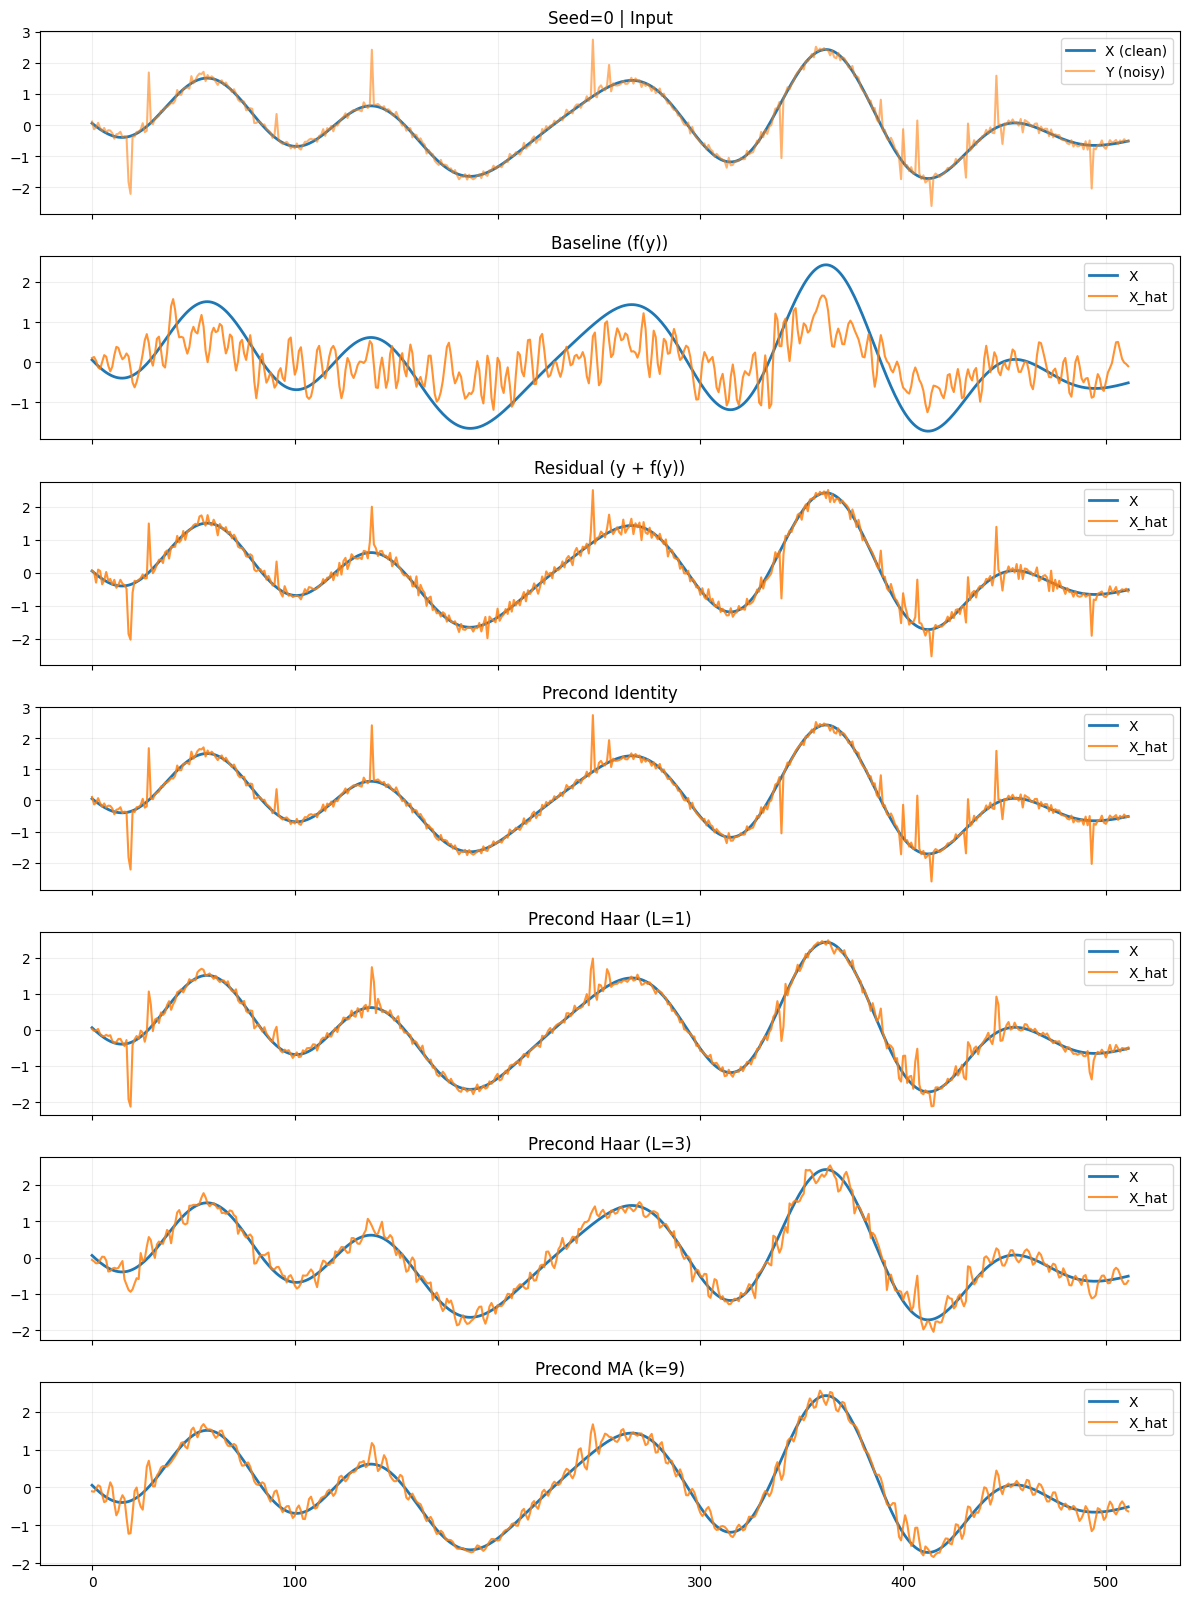

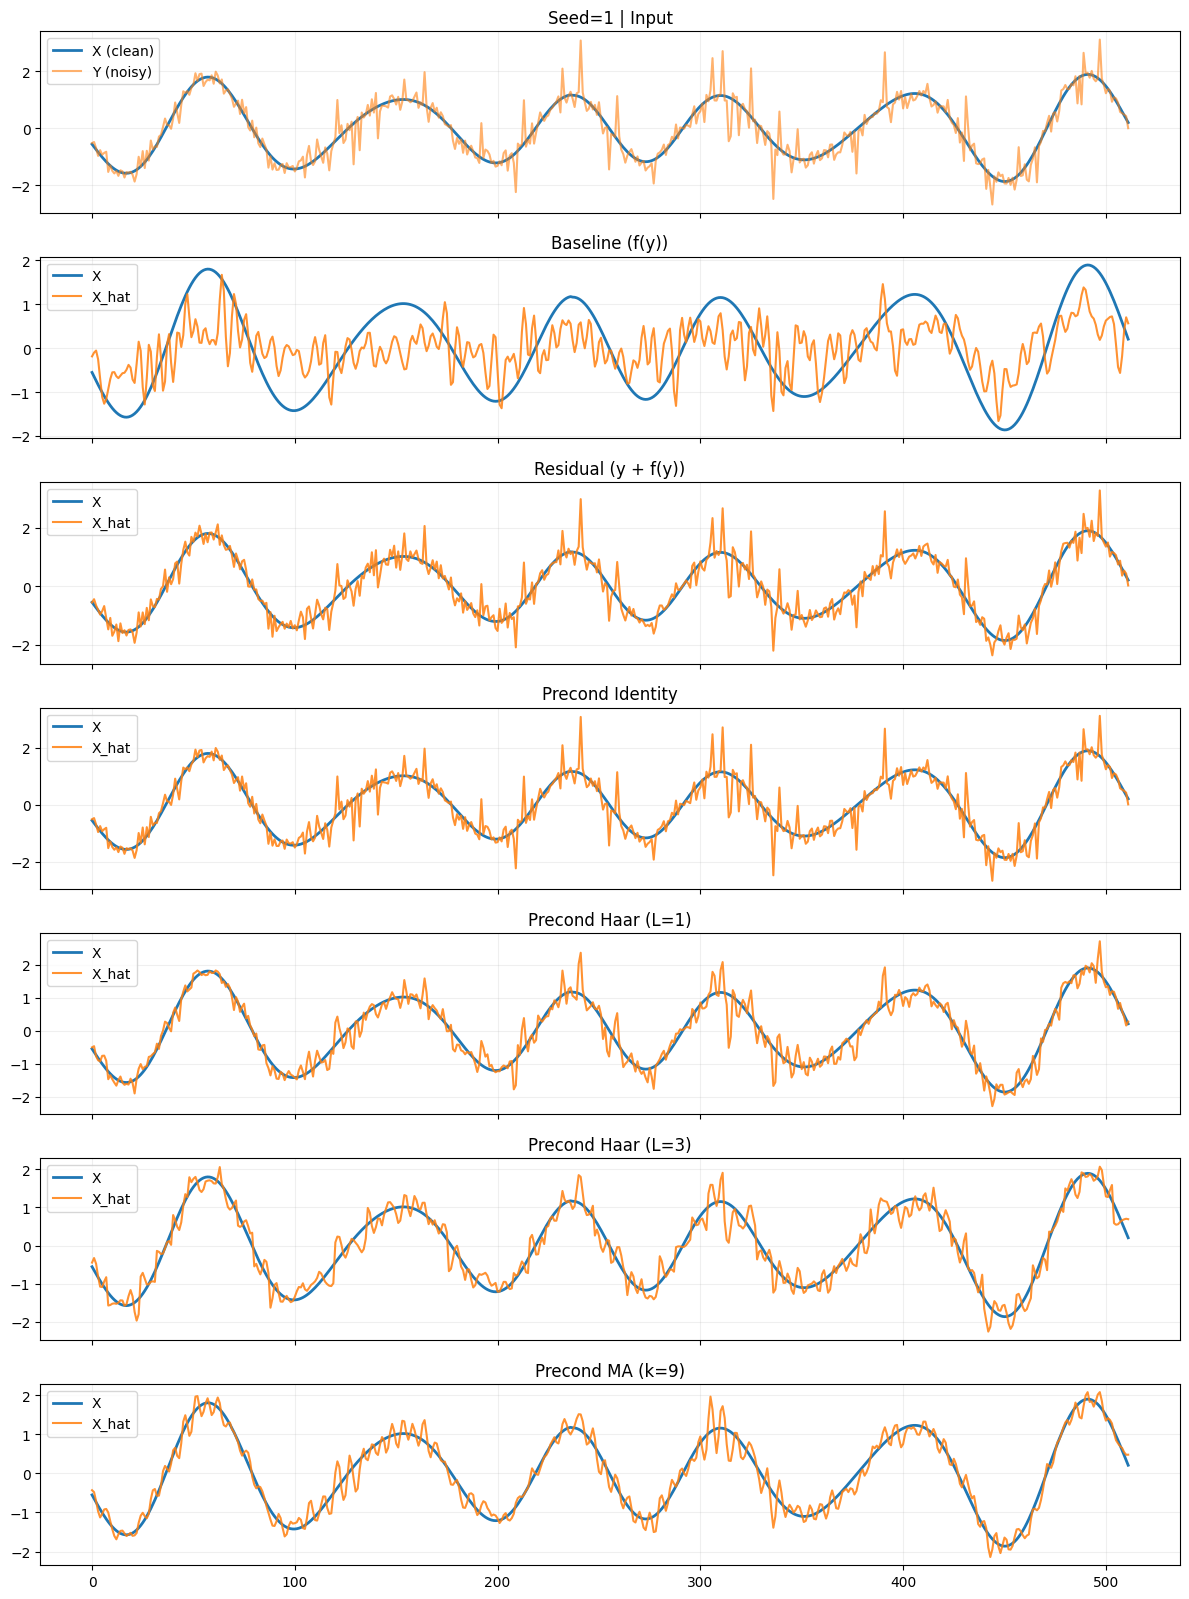

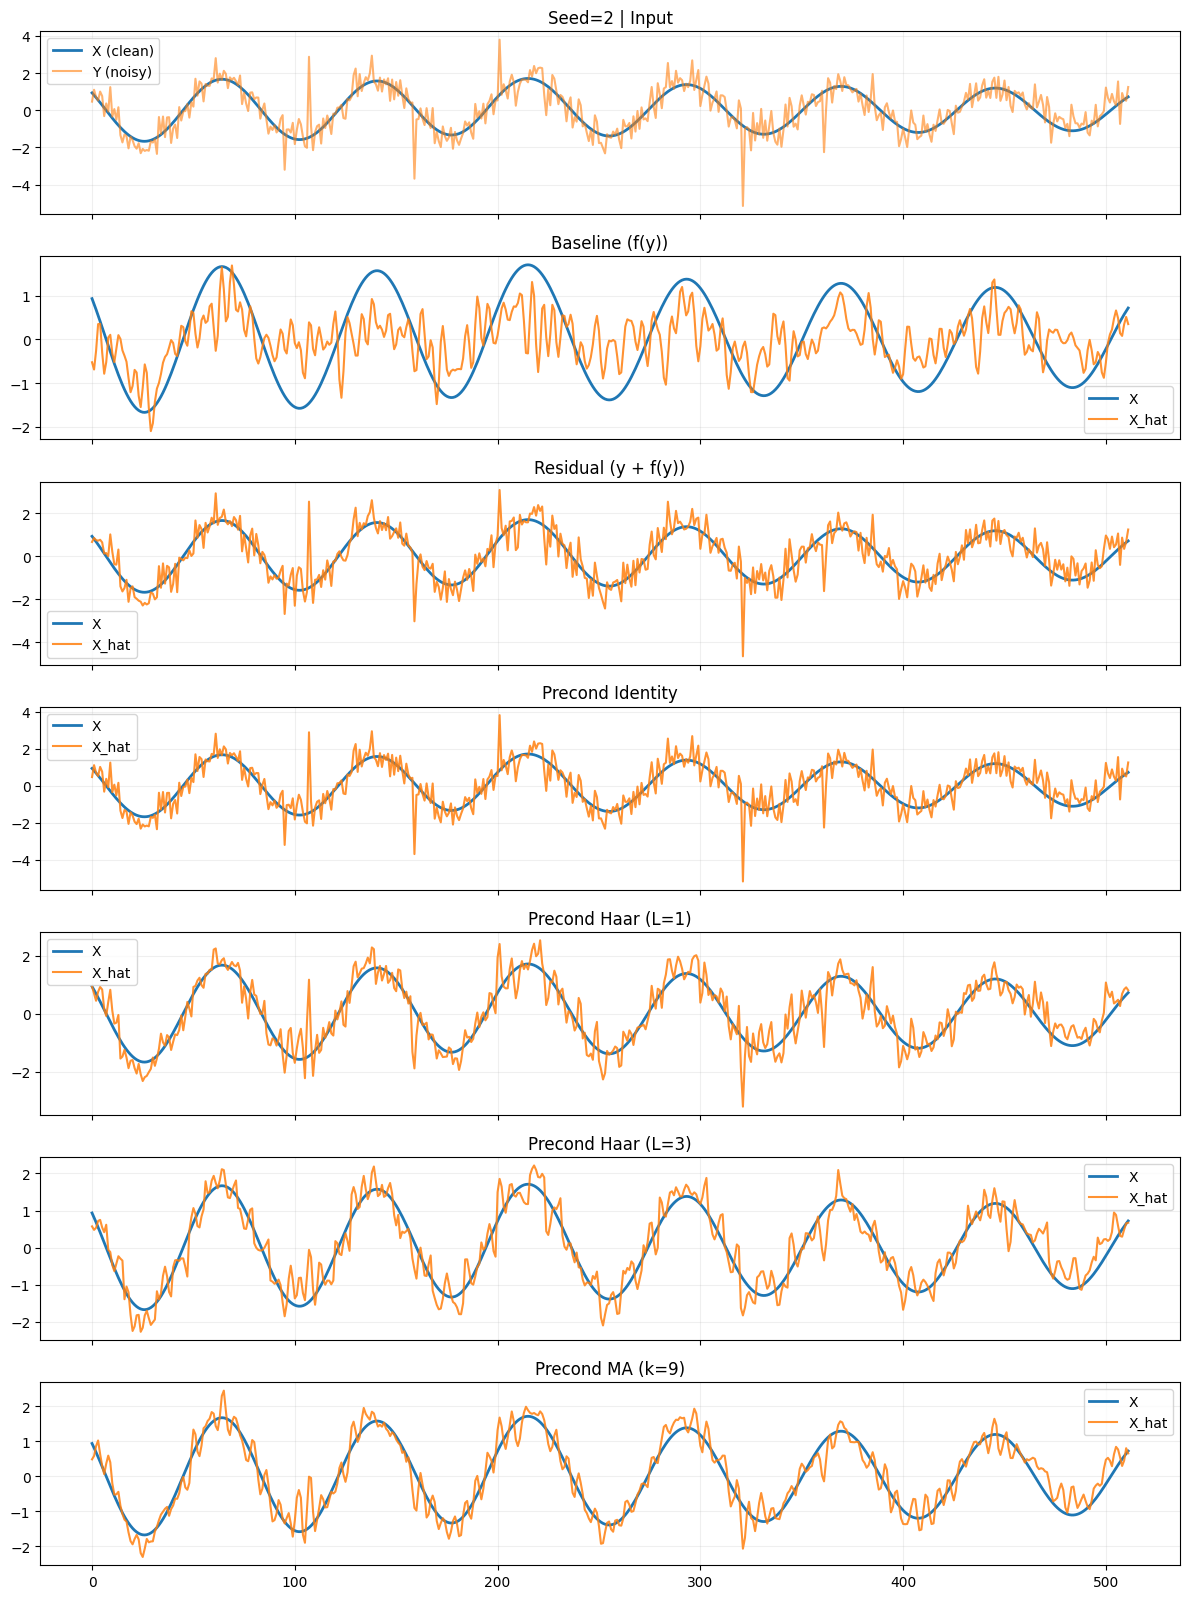

,name,version,best_val,mse,mse_lf,mse_hf
5,Precond MA (k=9),version_11,0.484730,0.069936,0.020801,0.049134
4,Precond Haar (L=3),version_10,0.527544,0.094782,0.031830,0.062952
3,Precond Haar (L=1),version_9,0.240035,0.126889,0.032015,0.094874
1,Residual (y + f(y)),version_7,0.251715,0.197290,0.031141,0.166149
2,Precond Identity,version_8,0.292101,0.226996,0.031818,0.195178
0,Baseline (f(y)),version_6,0.737762,0.613344,0.473068,0.140276


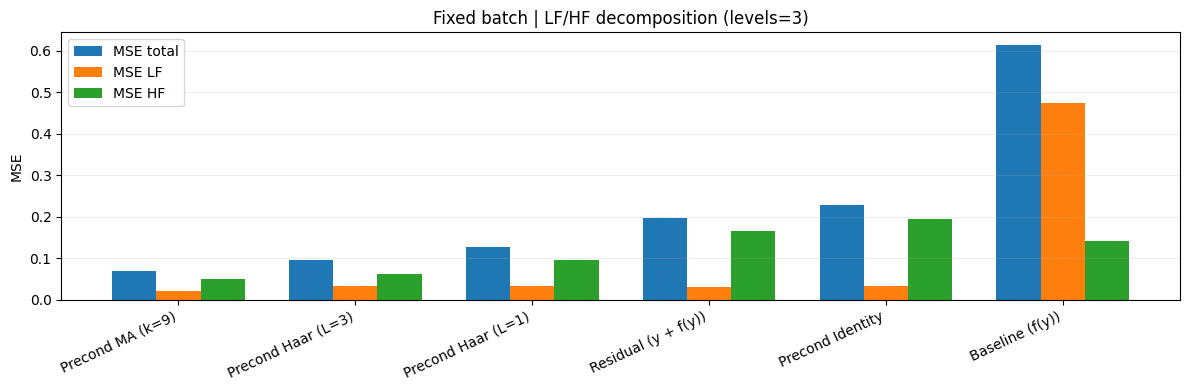

In [87]:
import os, glob, re
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from IPython.display import display

from src.models.regression_model import RegressionModel
from src.data.signal_1d import Signal1DConfig, generate_pair
from src.models.wavelet_1d import haar_lowpass_reconstruct

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

CACHE_DIR = "./.cache"
CKPT_DIR = os.path.join(CACHE_DIR, "checkpoints")
LOG_DIR  = os.path.join(CACHE_DIR, "lightning_logs")

RUN_VERSION = {
    "Baseline (f(y))": "version_6",
    "Residual (y + f(y))": "version_7",
    "Precond Identity": "version_8",
    "Precond Haar (L=1)": "version_9",
    "Precond Haar (L=3)": "version_10",
    "Precond MA (k=9)": "version_11",
}

def _read_metrics(version: str) -> pd.DataFrame:
    path = os.path.join(LOG_DIR, version, "metrics.csv")
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing metrics.csv: {path}")
    return pd.read_csv(path)

def _best_epoch_and_val(version: str) -> tuple[int, float]:
    df = _read_metrics(version)
    d = df.dropna(subset=["epoch", "val_loss"]).copy()
    if len(d) == 0:
        raise ValueError(f"No val_loss found in {version}/metrics.csv")
    d["epoch"] = d["epoch"].astype(int)
    best = d.sort_values(["val_loss", "epoch"], ascending=[True, True]).iloc[0]
    return int(best["epoch"]), float(best["val_loss"])

def _parse_val_loss_from_ckpt_name(path: str) -> float:
    m = re.search(r"val_loss=([0-9]+(?:\.[0-9]+)?)", os.path.basename(path))
    return float(m.group(1)) if m else float("inf")

def _find_ckpt(epoch: int, val: float) -> str:
    val6 = f"{val:.6f}"
    exact = glob.glob(os.path.join(CKPT_DIR, f"*epoch={epoch}*-val_loss={val6}*.ckpt"))
    if len(exact) >= 1:
        exact.sort(key=os.path.getmtime, reverse=True)
        return exact[0]

    cands = glob.glob(os.path.join(CKPT_DIR, f"*epoch={epoch}*-val_loss=*.ckpt"))
    if len(cands) == 0:
        raise FileNotFoundError(f"No checkpoint found for epoch={epoch} in {CKPT_DIR}")
    cands.sort(key=lambda p: abs(_parse_val_loss_from_ckpt_name(p) - val))
    return cands[0]

def load_best_model(version: str):
    epoch, best_val = _best_epoch_and_val(version)
    ckpt = _find_ckpt(epoch, best_val)
    model = RegressionModel.load_from_checkpoint(
        ckpt, map_location=device, weights_only=False
    ).to(device).eval()
    return model, ckpt, epoch, best_val

def fixed_batch(cfg: Signal1DConfig, seeds):
    xs, ys = [], []
    for s in seeds:
        x, y = generate_pair(cfg, seed=int(s), device=torch.device("cpu"))
        xs.append(x)
        ys.append(y)
    X = torch.stack(xs).to(device)
    Y = torch.stack(ys).to(device)
    return Y, X

@torch.no_grad()
def plot_recons_clean(models: dict, Y: torch.Tensor, X: torch.Tensor, seeds):
    B, L = X.shape
    t = np.arange(L)

    for i in range(B):
        fig, axes = plt.subplots(1 + len(models), 1, figsize=(12, 2.3*(1+len(models))), sharex=True)

        axes[0].plot(t, X[i].cpu().numpy(), label="X (clean)", linewidth=2)
        axes[0].plot(t, Y[i].cpu().numpy(), label="Y (noisy)", alpha=0.6)
        axes[0].set_title(f"Seed={seeds[i]} | Input")
        axes[0].legend()
        axes[0].grid(alpha=0.2)

        for k, (name, obj) in enumerate(models.items(), start=1):
            m = obj["model"]
            xhat = m(Y[i:i+1]).squeeze(0)
            axes[k].plot(t, X[i].cpu().numpy(), label="X", linewidth=2)
            axes[k].plot(t, xhat.cpu().numpy(), label="X_hat", alpha=0.85)
            axes[k].set_title(name)
            axes[k].legend()
            axes[k].grid(alpha=0.2)

        plt.tight_layout()
        plt.show()

def lf_hf(x: torch.Tensor, levels: int = 3):
    x_lf = haar_lowpass_reconstruct(x, levels=levels)
    return x_lf, x - x_lf

@torch.no_grad()
def eval_mse_lf_hf(model, Y, X, lf_levels=3):
    Xhat = model(Y)
    mse = torch.mean((Xhat - X) ** 2).item()

    X_lf, X_hf = lf_hf(X, levels=lf_levels)
    Xhat_lf, Xhat_hf = lf_hf(Xhat, levels=lf_levels)

    mse_lf = torch.mean((Xhat_lf - X_lf) ** 2).item()
    mse_hf = torch.mean((Xhat_hf - X_hf) ** 2).item()
    return mse, mse_lf, mse_hf

# Run
cfg = Signal1DConfig(L=512, use_steps=True, use_spikes=True, do_standardize=True)
seeds = [0, 1, 2]
Y_fix, X_fix = fixed_batch(cfg, seeds)

models = {}
for name, version in RUN_VERSION.items():
    m, ckpt, ep, best = load_best_model(version)
    models[name] = {"model": m, "ckpt": ckpt, "epoch": ep, "best_val": best}
    print(f"{name}: {version} | epoch={ep} | best_val={best:.6f} | ckpt={os.path.basename(ckpt)}")

plot_recons_clean(models, Y_fix, X_fix, seeds)

lf_levels = 3
rows = []
for name, obj in models.items():
    mse, mse_lf, mse_hf = eval_mse_lf_hf(obj["model"], Y_fix, X_fix, lf_levels=lf_levels)
    rows.append({
        "name": name,
        "version": RUN_VERSION[name],
        "best_val": obj["best_val"],
        "mse": mse,
        "mse_lf": mse_lf,
        "mse_hf": mse_hf,
    })

df = pd.DataFrame(rows).sort_values("mse")
display(df)

names = df["name"].tolist()
x = np.arange(len(names))
w = 0.25

plt.figure(figsize=(12, 4))
plt.bar(x - w, df["mse"].values, w, label="MSE total")
plt.bar(x,     df["mse_lf"].values, w, label="MSE LF")
plt.bar(x + w, df["mse_hf"].values, w, label="MSE HF")
plt.xticks(x, names, rotation=25, ha="right")
plt.ylabel("MSE")
plt.title(f"Fixed batch | LF/HF decomposition (levels={lf_levels})")
plt.grid(axis="y", alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()

Faire l'analyse des résultats (TO DOOOO)

## Expérience B — Rôle des skip connections dans les architectures de type U-Net

Après avoir étudié l’impact du préconditionnement dans un cadre 1D simple, cette seconde expérience vise à analyser un autre mécanisme central des architectures U-Net : les **skip connections**.

Les skip connections constituent un élément fondamental des U-Nets classiques. Elles permettent de transmettre directement des informations issues des niveaux de résolution grossiers vers les niveaux de reconstruction fine, contournant ainsi les goulots d’étranglement introduits par les opérations de sous-échantillonnage.  

L’article *A Unified Framework for U-Net Design and Analysis* insiste sur le fait que ces connexions ne doivent pas être vues uniquement comme un artifice architectural, mais comme un mécanisme structurel essentiel pour préserver l’information locale et stabiliser l’optimisation.

L’objectif de cette expérience est donc de **quantifier et visualiser empiriquement** le rôle des skip connections dans un cadre contrôlé de débruitage 1D.

---

## Objectif de l’expérience

L’expérience B vise à tester l’hypothèse suivante :

> **Les skip connections jouent un rôle clé dans la reconstruction des composantes fines du signal et dans la stabilité de l’apprentissage, indépendamment du préconditionnement explicite.**

Pour cela, on compare deux modèles strictement identiques :

- un **U-Net 1D standard**, avec skip connections actives,
- un **U-Net 1D ablaté**, où les skip connections sont remplacées par des tenseurs nuls lors de la phase de décodage.

Cette ablation permet d’isoler précisément l’effet des skip connections, sans modifier :
- la profondeur du réseau,
- le nombre de paramètres,
- la fonction de perte,
- les données d’entraînement,
- ou le protocole d’optimisation.

---

## Architecture considérée

Le modèle utilisé est un **U-Net 1D** adapté à une tâche de régression (débruitage), construit par analogie directe avec le U-Net 2D classique :

- **Encodeur** :
  - blocs convolutifs 1D (DoubleConv),
  - sous-échantillonnage par max-pooling,
- **Bottleneck** :
  - traitement à la résolution la plus grossière,
- **Décodeur** :
  - sur-échantillonnage linéaire,
  - concaténation avec les représentations issues de l’encodeur (skip connections),
  - blocs convolutifs de reconstruction.

Dans la version *sans skip connections*, les tenseurs de saut sont explicitement remplacés par des zéros de même dimension, garantissant une comparaison équitable.

---

## Cadre expérimental

Les deux modèles sont entraînés sur le même jeu de données synthétiques 1D que dans l’expérience A :

- signaux propres composés de sinusoïdes, discontinuités et événements localisés,
- bruit additif gaussien et impulsif,
- normalisation identique pour l’entrée et la cible.

Les métriques d’évaluation incluent :
- la **loss MSE** sur les ensembles d’entraînement et de validation,
- une **analyse qualitative** via la visualisation des signaux reconstruits,
- une **analyse fréquentielle** séparant basses fréquences (LF) et hautes fréquences (HF),
- des statistiques globales sur un ensemble de test fixé.



In [82]:
# U-Net 1D avec skip
!python main.py task@_global_=regression data=signal_1d model=denoiser_unet1d \
  seed=0 trainer.deterministic=true trainer.benchmark=false \
  model.model.skip_mode=on \
  output_id=signal1d_unet_skip_on

# U-Net 1D sans skip (ablation)
!python main.py task@_global_=regression data=signal_1d model=denoiser_unet1d \
  seed=0 trainer.deterministic=true trainer.benchmark=false \
  model.model.skip_mode=off \
  output_id=signal1d_unet_skip_off

Seed set to 0
seed: 0
output_dir: .cache
output_id: signal1d_unet_skip_on
trainer:
  _target_: pytorch_lightning.Trainer
  max_epochs: 15
  accelerator: auto
  log_every_n_steps: 10
  check_val_every_n_epoch: 1
  limit_val_batches: 1.0
  deterministic: true
  benchmark: false
  enable_checkpointing: true
  enable_progress_bar: true
  callbacks:
  - _target_: pytorch_lightning.callbacks.EarlyStopping
    monitor: val_loss
    mode: min
    patience: 10
  - _target_: pytorch_lightning.callbacks.ModelCheckpoint
    monitor: val_loss
    mode: min
    save_top_k: 1
    dirpath: ./${output_dir}/checkpoints
    filename: ${now:%Y-%m-%d_%H-%M-%S}-epoch={epoch}-val_loss={val_loss:.6f}
model:
  _target_: src.models.regression_model.RegressionModel
  model:
    _target_: src.models.unet_1d.UNet1D
    in_channels: 1
    out_channels: 1
    dims:
    - 32
    - 64
    - 128
    - 256
    skip_mode: 'on'
  loss:
    _target_: torch.nn.MSELoss
  optimizer:
    _target_: torch.optim.AdamW
    lr: 0.0

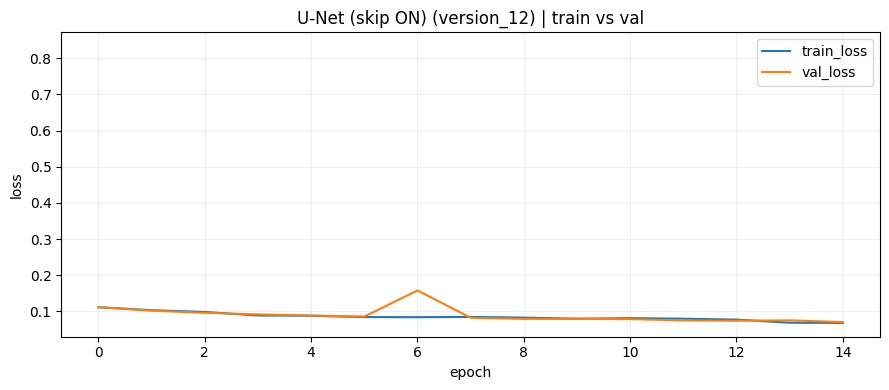

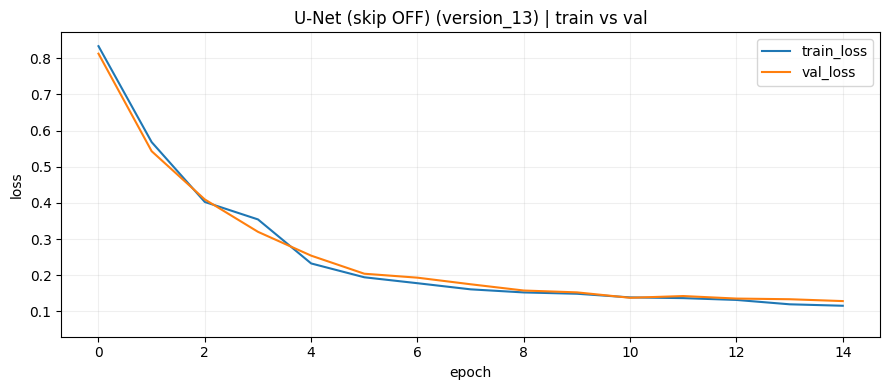

,name,version,best_epoch,best_val,train_last,val_last
0,U-Net (skip ON),version_12,14,0.070272,0.068047,0.070272
1,U-Net (skip OFF),version_13,14,0.128336,0.115442,0.128336


U-Net (skip ON): version_12 | best_epoch=14 | best_val=0.070272 | ckpt=2026-01-26_21-17-37-epoch=epoch=14-val_loss=val_loss=0.070272.ckpt
U-Net (skip OFF): version_13 | best_epoch=14 | best_val=0.128336 | ckpt=2026-01-26_21-39-44-epoch=epoch=14-val_loss=val_loss=0.128336.ckpt


,name,mse,mse_lf,mse_hf
0,U-Net (skip OFF),0.301985,0.258973,0.043012
1,U-Net (skip ON),0.563498,0.521344,0.042154


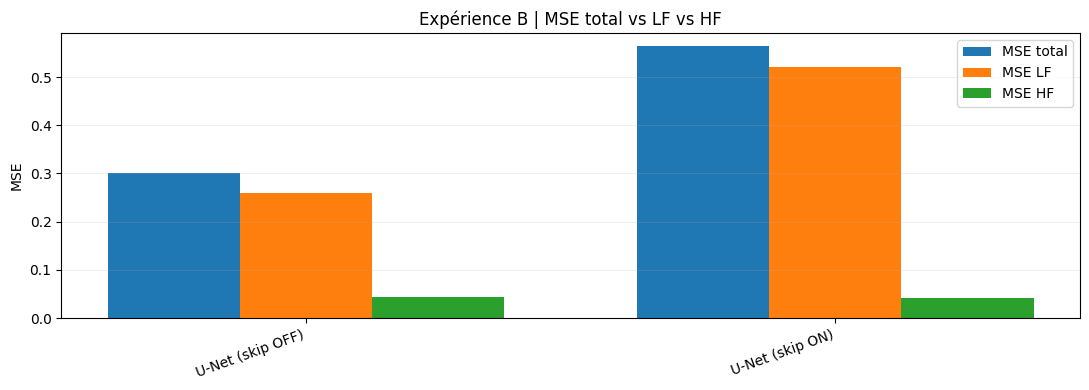

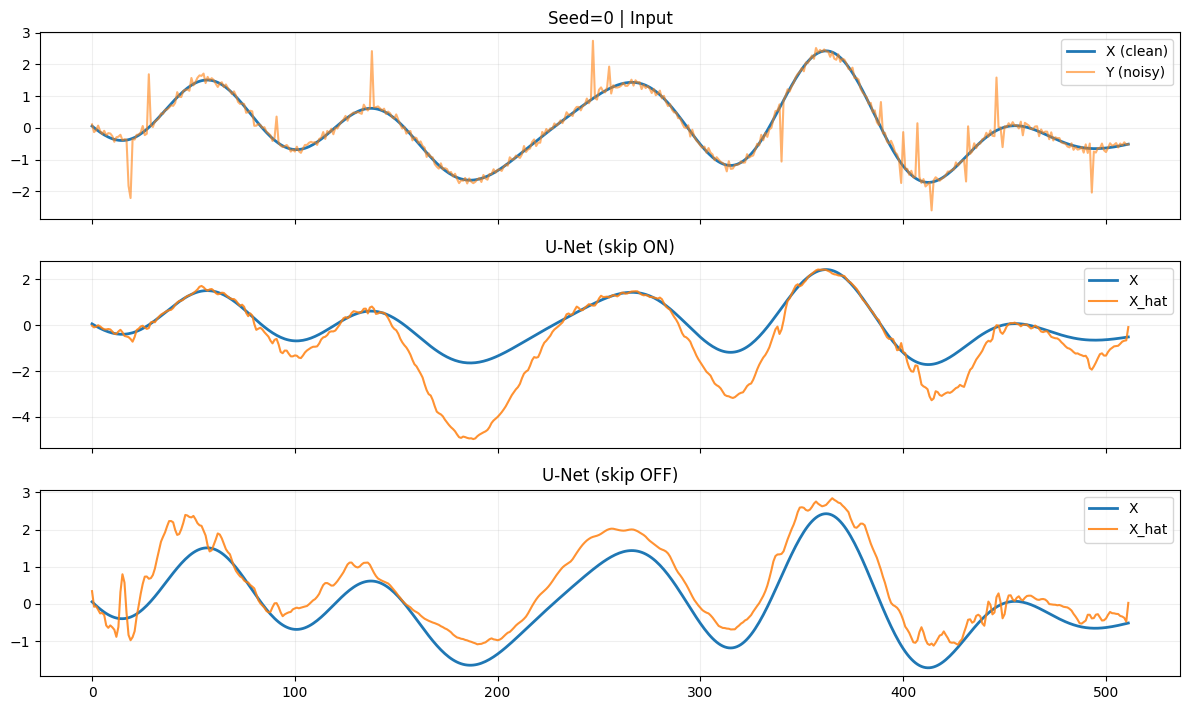

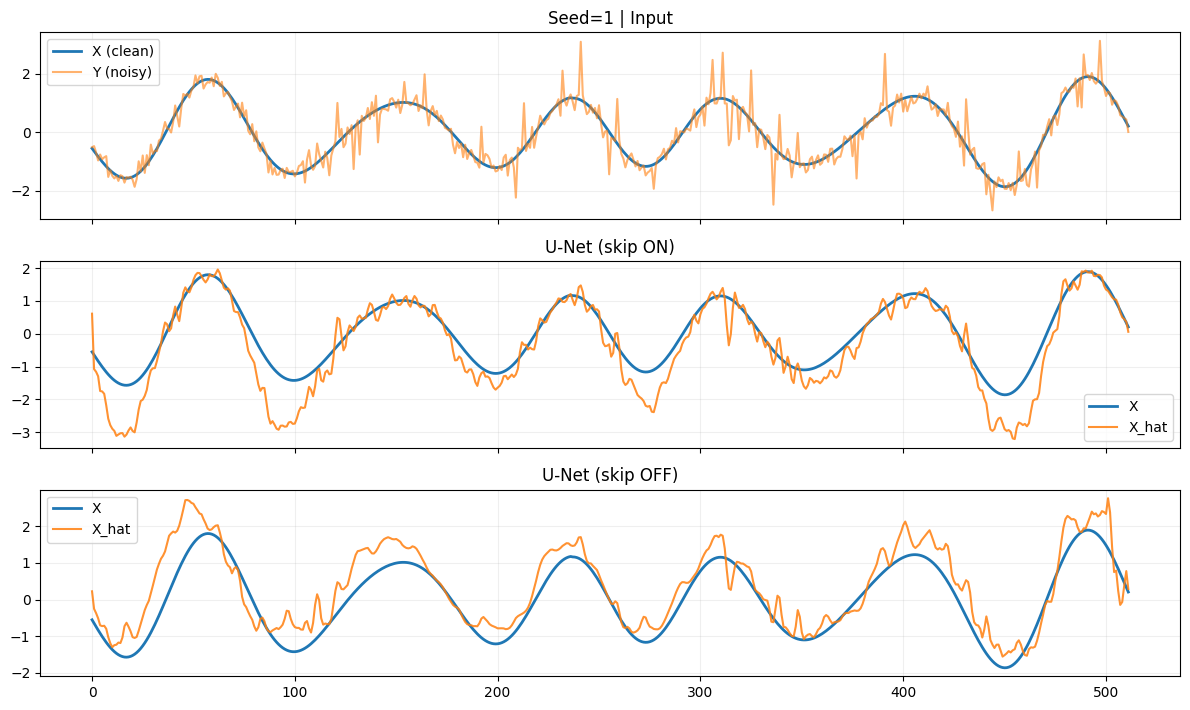

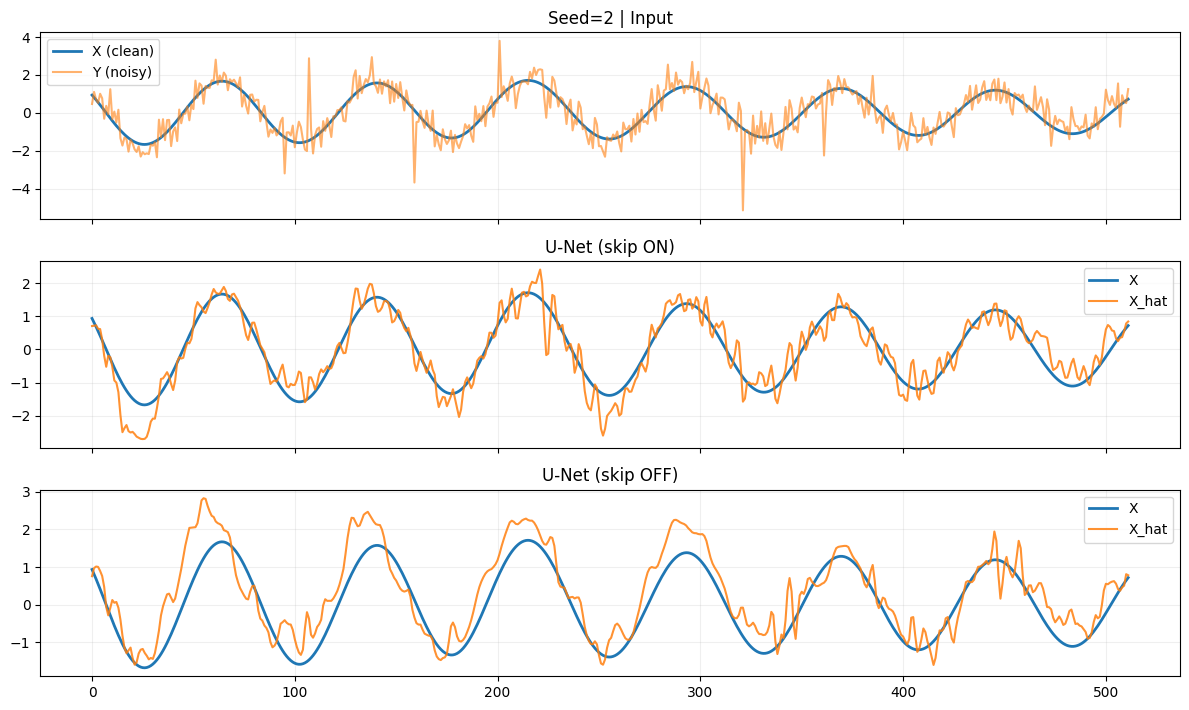

In [96]:
import os, glob, re
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from src.models.regression_model import RegressionModel
from src.data.signal_1d import Signal1DConfig, generate_pair
from src.models.wavelet_1d import haar_lowpass_reconstruct

# -------------------------
# Paths + device
# -------------------------
CACHE_DIR = "./.cache"
LOG_DIR  = os.path.join(CACHE_DIR, "lightning_logs")
CKPT_DIR = os.path.join(CACHE_DIR, "checkpoints")

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# -------------------------
# Tes versions (à adapter)
# -------------------------
RUN_VERSION = {
    "U-Net (skip ON)":  "version_12",
    "U-Net (skip OFF)": "version_13",
}

# -------------------------
# Metrics helpers
# -------------------------
def read_metrics(version: str) -> pd.DataFrame:
    path = os.path.join(LOG_DIR, version, "metrics.csv")
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing metrics.csv: {path}")
    return pd.read_csv(path)

def curve_per_epoch(df: pd.DataFrame, key: str) -> pd.DataFrame:
    """Return last logged value per epoch for metric `key`."""
    if key not in df.columns:
        return pd.DataFrame(columns=["epoch", key])
    d = df.dropna(subset=["epoch", key]).copy()
    if d.empty:
        return pd.DataFrame(columns=["epoch", key])
    d["epoch"] = d["epoch"].astype(int)
    if "step" in d.columns:
        d = d.sort_values(["epoch", "step"]).groupby("epoch", as_index=False).tail(1)
    else:
        d = d.sort_values(["epoch"]).groupby("epoch", as_index=False).tail(1)
    return d[["epoch", key]].sort_values("epoch").reset_index(drop=True)

def best_epoch_val(df: pd.DataFrame) -> tuple[int, float]:
    d = df.dropna(subset=["epoch", "val_loss"]).copy()
    if d.empty:
        raise ValueError("val_loss not found in metrics.csv")
    d["epoch"] = d["epoch"].astype(int)
    d["val_loss"] = d["val_loss"].astype(float)
    row = d.sort_values(["val_loss", "epoch"], ascending=[True, True]).iloc[0]
    return int(row["epoch"]), float(row["val_loss"])

# -------------------------
# Checkpoint helpers
# -------------------------
def _val_from_ckpt_name(path: str) -> float:
    m = re.search(r"val_loss=([0-9]+(?:\.[0-9]+)?)", os.path.basename(path))
    return float(m.group(1)) if m else float("inf")

def find_ckpt(best_ep: int, best_val: float) -> str:
    # 1) try exact val at 6 decimals for that epoch
    v6 = f"{best_val:.6f}"
    exact = glob.glob(os.path.join(CKPT_DIR, f"*epoch={best_ep}*-val_loss={v6}*.ckpt"))
    if exact:
        exact.sort(key=os.path.getmtime, reverse=True)
        return exact[0]

    # 2) try epoch match, pick closest val from filename
    cands = glob.glob(os.path.join(CKPT_DIR, f"*epoch={best_ep}*-val_loss=*.ckpt"))
    if not cands:
        raise FileNotFoundError(f"No checkpoint found for epoch={best_ep} in {CKPT_DIR}")
    cands.sort(key=lambda p: abs(_val_from_ckpt_name(p) - best_val))
    return cands[0]

def load_best_model(version: str):
    df = read_metrics(version)
    best_ep, best_val = best_epoch_val(df)
    ckpt = find_ckpt(best_ep, best_val)

    # IMPORTANT PyTorch 2.6 + OmegaConf in checkpoint
    model = RegressionModel.load_from_checkpoint(
        ckpt,
        map_location=device,
        weights_only=False,
    ).to(device).eval()

    return model, ckpt, best_ep, best_val

# -------------------------
# Plot helpers
# -------------------------
def plot_train_val_all_same_ylim(run_version: dict):
    curves = []
    for name, v in run_version.items():
        df = read_metrics(v)
        tr = curve_per_epoch(df, "train_loss")
        va = curve_per_epoch(df, "val_loss")
        curves.append((name, v, tr, va))

    all_vals = []
    for _, _, tr, va in curves:
        if not tr.empty: all_vals += tr["train_loss"].astype(float).tolist()
        if not va.empty: all_vals += va["val_loss"].astype(float).tolist()

    if not all_vals:
        raise ValueError("No train_loss/val_loss found in metrics.csv files.")

    ymin, ymax = float(min(all_vals)), float(max(all_vals))
    pad = 0.05 * (ymax - ymin + 1e-12)
    ylim = (ymin - pad, ymax + pad)

    for name, v, tr, va in curves:
        plt.figure(figsize=(9, 4))
        if not tr.empty:
            plt.plot(tr["epoch"], tr["train_loss"].astype(float), label="train_loss")
        if not va.empty:
            plt.plot(va["epoch"], va["val_loss"].astype(float), label="val_loss")
        plt.ylim(*ylim)
        plt.title(f"{name} ({v}) | train vs val")
        plt.xlabel("epoch"); plt.ylabel("loss")
        plt.grid(alpha=0.2); plt.legend()
        plt.tight_layout(); plt.show()

def summary_table(run_version: dict) -> pd.DataFrame:
    rows = []
    for name, v in run_version.items():
        df = read_metrics(v)
        tr = curve_per_epoch(df, "train_loss")
        va = curve_per_epoch(df, "val_loss")
        best_ep, best_val = best_epoch_val(df)
        rows.append({
            "name": name,
            "version": v,
            "best_epoch": best_ep,
            "best_val": best_val,
            "train_last": float(tr["train_loss"].iloc[-1]) if not tr.empty else np.nan,
            "val_last": float(va["val_loss"].iloc[-1]) if not va.empty else np.nan,
        })
    return pd.DataFrame(rows).sort_values("best_val").reset_index(drop=True)

# -------------------------
# Fixed batch + LF/HF eval
# -------------------------
def make_batch(cfg: Signal1DConfig, seeds, device=device):
    xs, ys = [], []
    for s in seeds:
        x, y = generate_pair(cfg, seed=int(s), device=torch.device("cpu"))
        xs.append(x); ys.append(y)
    X = torch.stack(xs).to(device)
    Y = torch.stack(ys).to(device)
    return Y, X

def lf_hf(x: torch.Tensor, levels: int = 3):
    x_lf = haar_lowpass_reconstruct(x, levels=levels)
    return x_lf, x - x_lf

@torch.no_grad()
def eval_mse_lf_hf(model, Y, X, levels=3):
    Xhat = model(Y)
    mse = torch.mean((Xhat - X) ** 2).item()

    X_lf, X_hf = lf_hf(X, levels)
    Xhat_lf, Xhat_hf = lf_hf(Xhat, levels)

    mse_lf = torch.mean((Xhat_lf - X_lf) ** 2).item()
    mse_hf = torch.mean((Xhat_hf - X_hf) ** 2).item()
    return mse, mse_lf, mse_hf

@torch.no_grad()
def plot_recons(models: dict, Y: torch.Tensor, X: torch.Tensor, seeds):
    B, L = X.shape
    t = np.arange(L)

    for i in range(B):
        fig, axes = plt.subplots(1 + len(models), 1, figsize=(12, 2.4*(1+len(models))), sharex=True)

        axes[0].plot(t, X[i].cpu().numpy(), label="X (clean)", linewidth=2)
        axes[0].plot(t, Y[i].cpu().numpy(), label="Y (noisy)", alpha=0.6)
        axes[0].set_title(f"Seed={seeds[i]} | Input")
        axes[0].legend(); axes[0].grid(alpha=0.2)

        for k, (name, m) in enumerate(models.items(), start=1):
            xhat = m(Y[i:i+1]).squeeze(0)
            axes[k].plot(t, X[i].cpu().numpy(), label="X", linewidth=2)
            axes[k].plot(t, xhat.cpu().numpy(), label="X_hat", alpha=0.85)
            axes[k].set_title(name)
            axes[k].legend(); axes[k].grid(alpha=0.2)

        plt.tight_layout()
        plt.show()

# ============================================================
# EXEC
# ============================================================

# 1) Loss curves (same y-scale across models)
plot_train_val_all_same_ylim(RUN_VERSION)

# 2) Summary table
df_sum = summary_table(RUN_VERSION)
display(df_sum)

# 3) Load best models
models = {}
for name, v in RUN_VERSION.items():
    m, ckpt, ep, best = load_best_model(v)
    models[name] = m
    print(f"{name}: {v} | best_epoch={ep} | best_val={best:.6f} | ckpt={os.path.basename(ckpt)}")

# 4) Quant eval on fixed batch
cfg_test = Signal1DConfig(L=512, use_steps=True, use_spikes=True, do_standardize=True)
seeds_eval = list(range(1000, 1300))  # 300 examples
Y_eval, X_eval = make_batch(cfg_test, seeds_eval)

rows = []
for name, m in models.items():
    mse, mse_lf, mse_hf = eval_mse_lf_hf(m, Y_eval, X_eval, levels=3)
    rows.append({"name": name, "mse": mse, "mse_lf": mse_lf, "mse_hf": mse_hf})

df_eval = pd.DataFrame(rows).sort_values("mse").reset_index(drop=True)
display(df_eval)

# 5) Bar plot
plt.figure(figsize=(11, 4))
x = np.arange(len(df_eval))
w = 0.25
plt.bar(x - w, df_eval["mse"], w, label="MSE total")
plt.bar(x,     df_eval["mse_lf"], w, label="MSE LF")
plt.bar(x + w, df_eval["mse_hf"], w, label="MSE HF")
plt.xticks(x, df_eval["name"], rotation=20, ha="right")
plt.ylabel("MSE")
plt.title("Expérience B | MSE total vs LF vs HF")
plt.grid(axis="y", alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()

# 6) Visual check (3 signals)
seeds_visu = [0, 1, 2]
Y_vis, X_vis = make_batch(cfg_test, seeds_visu)
plot_recons(models, Y_vis, X_vis, seeds_visu)

### Analyse des résultats — Expérience B

Bien que le U-Net avec connexions de saut (skip ON) atteigne une perte de validation plus faible sur l’ensemble des données, une analyse fréquentielle révèle une dégradation significative des performances sur les basses fréquences.

L’étude de la décomposition LF/HF montre que :
- les deux modèles présentent des performances comparables sur les hautes fréquences,
- le U-Net sans skip connections reconstruit nettement mieux les composantes basses fréquences,
- les skip connections favorisent la propagation d’informations locales et de bruit, au détriment de la cohérence globale du signal.

Ces résultats indiquent que, pour des tâches de débruitage 1D orientées structure globale, la suppression des connexions de saut agit comme une forme de régularisation structurelle bénéfique.